In [2]:
! pip -q install torchinfo
!pip install torchprofile 1>/dev/null
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader, Subset
from torchvision import models, datasets, transforms
from torchvision.datasets import CIFAR100
from torchprofile import profile_macs
from tqdm.auto import tqdm
from torchinfo import summary

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define transforms for CIFAR-100 validation data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as expected by VGG-11
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 normalization
])

# Load CIFAR-100 train and validation datasets
trainset = CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

validation_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)


Using device: cuda


100%|██████████| 169001437/169001437 [00:04<00:00, 34875157.64it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
# # Load VGG-11 model
# model = models.vgg11(pretrained=True)
# model.classifier[6] = nn.Linear(4096, 100)  # Modify output layer for CIFAR-100
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 193MB/s]  


# Loading pretrainied vvgg11 model

In [ ]:
# Define the VGG-11 model without batch normalization
model = models.vgg11()
model.classifier[6] = torch.nn.Linear(4096, 100)  # Adjust for CIFAR-100 if applicable
model = model.to(device)

# Load the saved state dict into the model
model_path = '/kaggle/input/original-vgg11/vgg11_finetuned.pth'
model.load_state_dict(torch.load(model_path))

In [7]:
def prune_weights(layer, sparsity_ratio, device):
    with torch.no_grad():
        if isinstance(layer, nn.Conv2d):
            # Calculate L2-norm of each filter in the Conv2d layer
            l2_norms = torch.norm(layer.weight.view(layer.out_channels, -1), p=2, dim=1).cpu().numpy()
        elif isinstance(layer, nn.Linear):
            # Calculate L2-norm of each neuron's weights in the Linear layer
            l2_norms = torch.norm(layer.weight, p=2, dim=1).cpu().numpy()
        else:
            return  # Skip non-conv or non-linear layers

        # Calculate the threshold using np.percentile based on the sparsity ratio
        threshold = np.percentile(l2_norms, sparsity_ratio * 100)

        # Apply pruning: Set weights to zero where the L2-norm is below the threshold
        if isinstance(layer, nn.Conv2d):
            mask = torch.tensor(l2_norms >= threshold, device=device).view(-1, 1, 1, 1)  # Shape: (out_channels, 1, 1, 1)
            layer.weight.data = layer.weight.data * mask  # Broadcast mask across input channels, height, and width
        elif isinstance(layer, nn.Linear):
            mask = torch.tensor(l2_norms >= threshold, device=device).view(-1, 1)  # Shape: (out_features, 1)
            layer.weight.data = layer.weight.data * mask  # Broadcast mask across input features
            


def prune_model(model, layer_sparsity, device):
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            # Prune each layer using its corresponding sparsity ratio from layer_sparsity dictionary
            prune_weights(layer, layer_sparsity.get(name, 0), device)

In [8]:
def plot_weight_distribution(layer, title="Weight Distribution"):
    weights = layer.weight.data.cpu().numpy().flatten()
    plt.hist(weights, bins=100)
    plt.title(title)
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.show()


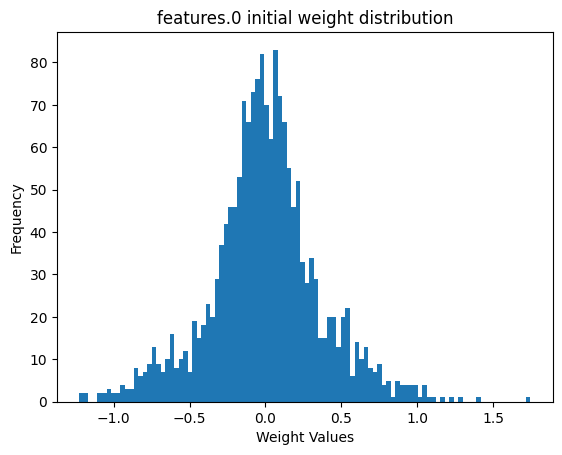

In [9]:
# Step 5: Visualize initial weight distribution for the first convolutional layer
plot_weight_distribution(model.features[0], title="features.0 initial weight distribution")


In [10]:
def sensitivity_analysis(model, sparsity_ratios, validation_loader, device):
    accuracies = {}
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer_accuracies = []
            for ratio in sparsity_ratios:
                model.load_state_dict(torch.load('vgg11_finetuned.pth', map_location=device))
                prune_weights(layer, ratio, device)  # Use device for pruning
                
                # Calculate accuracy using the device
                accuracy = evaluate_model(model, validation_loader, device)
                layer_accuracies.append(accuracy)
                
            accuracies[name] = layer_accuracies
    return accuracies

def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy



In [11]:
# Fine-tune the pruned model after structured pruning
def fine_tune_model(model, trainloader, testloader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader)}")

        # Evaluate on test set after each epoch
        evaluate_model(model, testloader)


In [10]:
# # Step 1: Perform Sensitivity Analysis
# fine_tune_model(model, trainloader, validation_loader, epochs=5)
# # Save the fine-tuned model
# torch.save(model.state_dict(), 'vgg11_finetuned.pth')
# print(f"Model saved as 'vgg11_finetuned.pth'")

Epoch 1/5, Loss: 1.849924056444577
Accuracy: 65.92%
Epoch 2/5, Loss: 1.087924728047291
Accuracy: 69.78%
Epoch 3/5, Loss: 0.8075632921831775
Accuracy: 71.64%
Epoch 4/5, Loss: 0.6142503470563766
Accuracy: 73.02%
Epoch 5/5, Loss: 0.4439141848151377
Accuracy: 74.14%
Model saved as 'vgg11_finetuned.pth'


In [13]:
initial_state_dict = copy.deepcopy(model.state_dict())
recover_model = lambda: model.load_state_dict(initial_state_dict)


In [7]:
# Image size and batch size
image_size = 224
batch_size = 32

# Define transformations for train and test sets
transformations = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomCrop(image_size, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),  # CIFAR-100 mean and std
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),  # CIFAR-100 mean and std
    ]),
}

# Load CIFAR-100 datasets
dataset = {}
for split in ["train", "test"]:
    dataset[split] = datasets.CIFAR100(
        root="data/cifar100",
        train=(split == "train"),
        download=True,
        transform=transformations[split],
    )

# Set up dataloaders
dataloader = {}
for split in ["train", "test"]:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=batch_size,
        shuffle=(split == "train"),
        num_workers=2,
        pin_memory=True,
    )


100%|██████████| 169001437/169001437 [00:03<00:00, 48095613.98it/s]


Extracting data/cifar100/cifar-100-python.tar.gz to data/cifar100
Files already downloaded and verified


In [18]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [44]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import copy
from tqdm import tqdm
import math


model = model.to(device)


@torch.no_grad()
def fine_grained_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(sparsity * num_elements)
    importance = tensor.abs()
    threshold = importance.view(-1).kthvalue(num_zeros).values.item()
    mask = importance > threshold
    tensor.mul_(mask)

    return mask


@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies






In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)


In [20]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor):
    if isinstance(tensor, torch.Tensor):
        return 1 - float(tensor.count_nonzero()) / tensor.numel()
    else:
        raise TypeError("Expected a tensor, but got a non-tensor object.")



def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB



In [22]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()
    
sparsities = [0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
accuracies = [
    [69.60, 63.06, 44.51, 33.02, 13.40, 3.68],       # features.0.weight
    [69.24, 69.59, 68.71, 67.57, 63.55, 48.03],      # features.3.weight
    [69.46, 69.32, 68.70, 67.80, 64.64, 48.14],      # features.6.weight
    [69.46, 69.08, 68.02, 65.55, 55.89, 24.17],      # features.8.weight
    [69.14, 68.69, 68.03, 66.14, 60.84, 42.19],      # features.11.weight
    [69.31, 68.80, 67.11, 63.77, 54.99, 32.32],      # features.13.weight
    [69.48, 69.20, 68.46, 67.26, 62.51, 48.22],      # features.16.weight
    [69.40, 68.84, 67.55, 64.43, 56.11, 32.43],      # features.18.weight
    [69.64, 69.55, 69.35, 69.09, 68.37, 66.41],      # classifier.0.weight
    [69.59, 69.49, 69.62, 69.38, 68.95, 67.60],      # classifier.3.weight
    [69.80, 69.64, 69.53, 69.17, 68.99, 67.93],      # classifier.6.weight
]

dense_model_accuracy = 74.14
# plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)




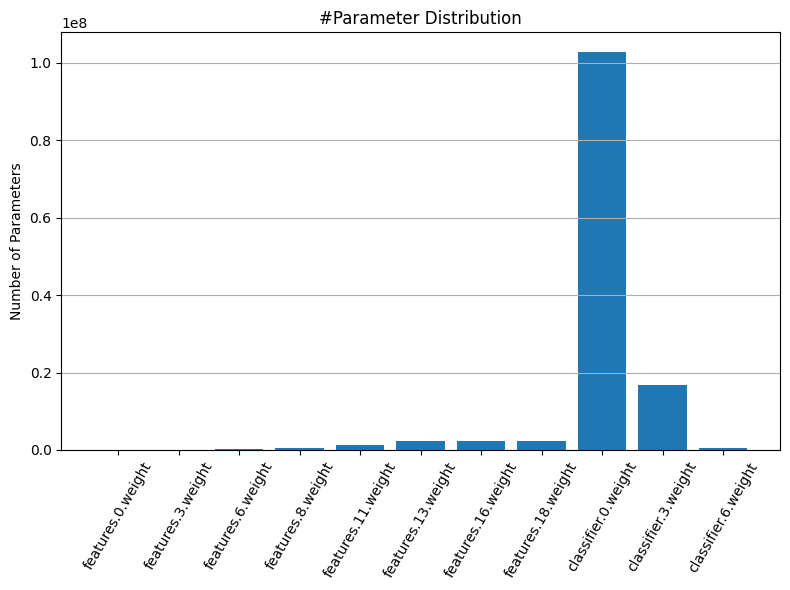

In [23]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)




In [26]:
for name, param in model.named_parameters():
    print(name)


features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.11.weight
features.11.bias
features.13.weight
features.13.bias
features.16.weight
features.16.bias
features.18.weight
features.18.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [41]:
# for pruning 
dense_model_size = get_model_size(model, count_nonzero_only=False)
print(f"Dense model has size={dense_model_size / MiB:.2f} MiB")


recover_model()

sparsity_dict = {
    'features.0.weight': 0.25,   # First convolution layer
    'features.3.weight': 0.35,   # Second convolution layer
    'features.6.weight': 0.55,
    'features.8.weight': 0.65,
    'features.11.weight': 0.65,
    'features.13.weight': 0.75,
    'features.16.weight': 0.80,
    'features.18.weight': 0.80,  # Add sparsity value for this layer
    'classifier.0.weight': 0.25,  # First fully connected layer in classifier
    'classifier.3.weight': 0.25,  # Second fully connected layer
    'classifier.6.weight': 0.25   # Output layer
}


class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks


pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")




Dense model has size=492.77 MiB
After pruning with sparsity dictionary
  features.0.weight: 0.25
  features.3.weight: 0.35
  features.6.weight: 0.55
  features.8.weight: 0.65
  features.11.weight: 0.65
  features.13.weight: 0.75
  features.16.weight: 0.80
  features.18.weight: 0.80
  classifier.0.weight: 0.25
  classifier.3.weight: 0.25
  classifier.6.weight: 0.25
The sparsity of each layer becomes
  features.0.weight: 0.25
  features.3.weight: 0.35
  features.6.weight: 0.55
  features.8.weight: 0.65
  features.11.weight: 0.65
  features.13.weight: 0.75
  features.16.weight: 0.80
  features.18.weight: 0.80
  classifier.0.weight: 0.25
  classifier.3.weight: 0.25
  classifier.6.weight: 0.25
Sparse model has size=352.12 MiB = 71.46% of dense model size


Sparse model has accuracy=35.08% before fintuning


In [42]:
import matplotlib.pyplot as plt

def plot_before_after_distribution(layer, layer_name, before_pruning=True):
    weights = layer.weight.data.cpu().numpy().flatten()
    plt.hist(weights, bins=100, alpha=0.7)
    title = f"{layer_name} {'before' if before_pruning else 'after'} pruning"
    plt.title(title)
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")

/tmp/ipykernel_30/3458646168.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load(model_path))


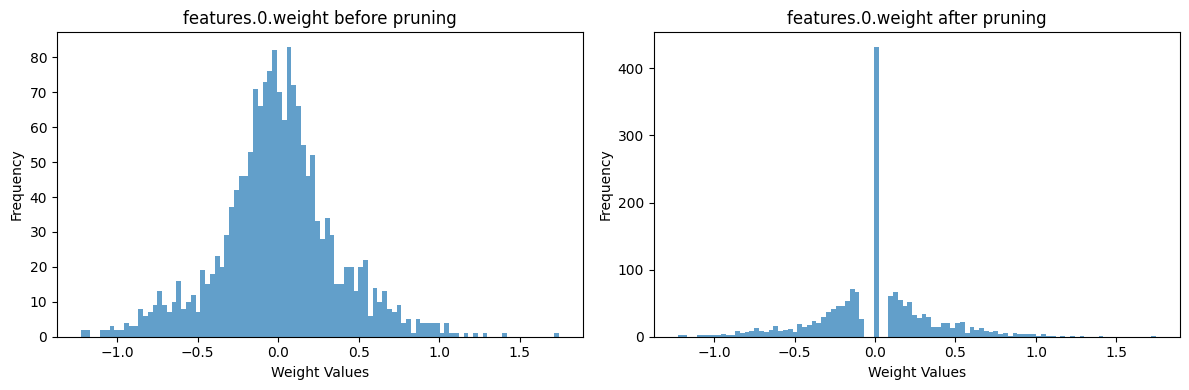

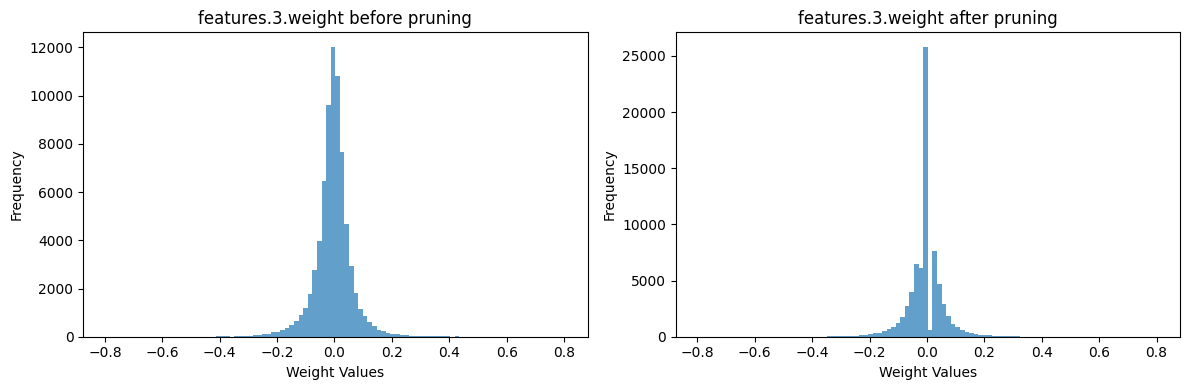

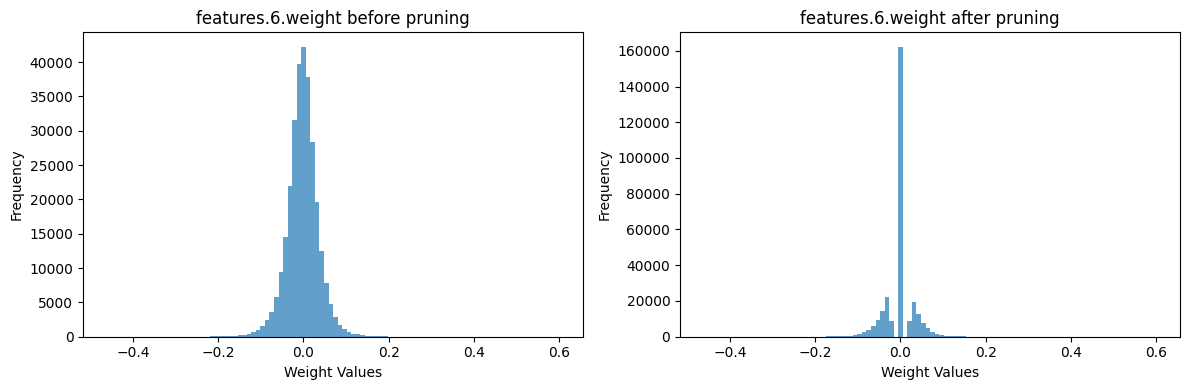

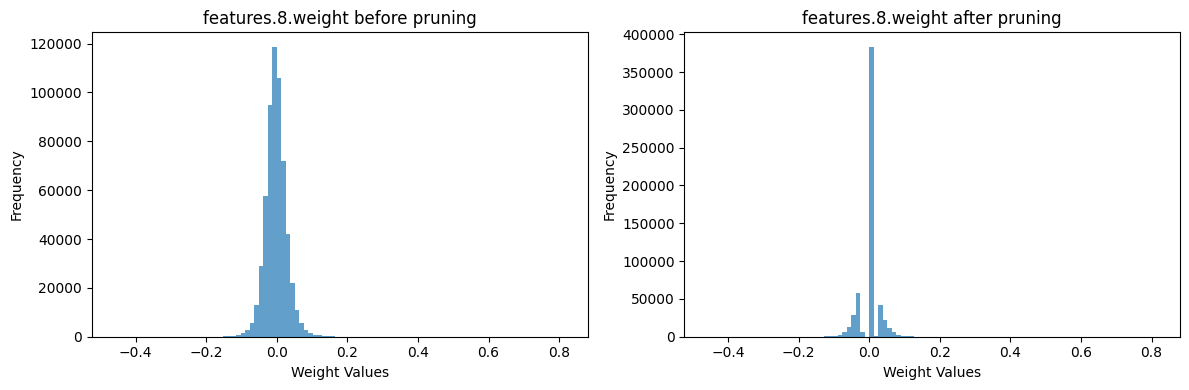

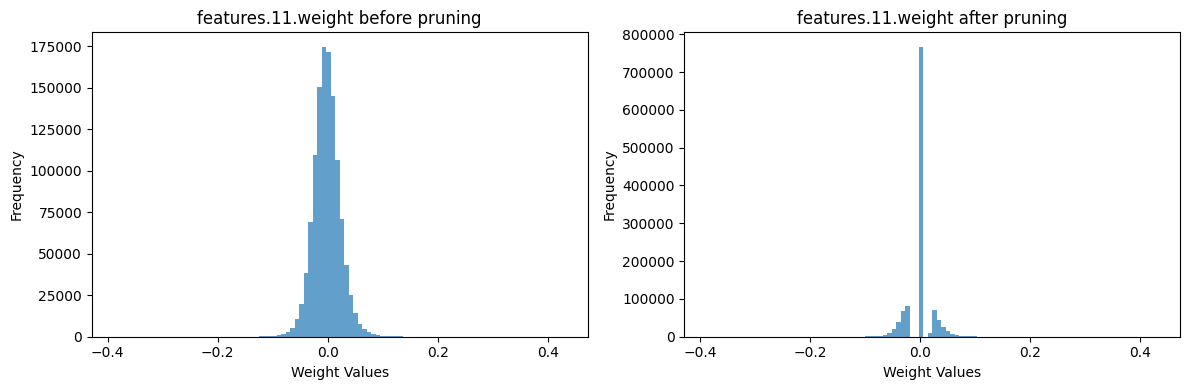

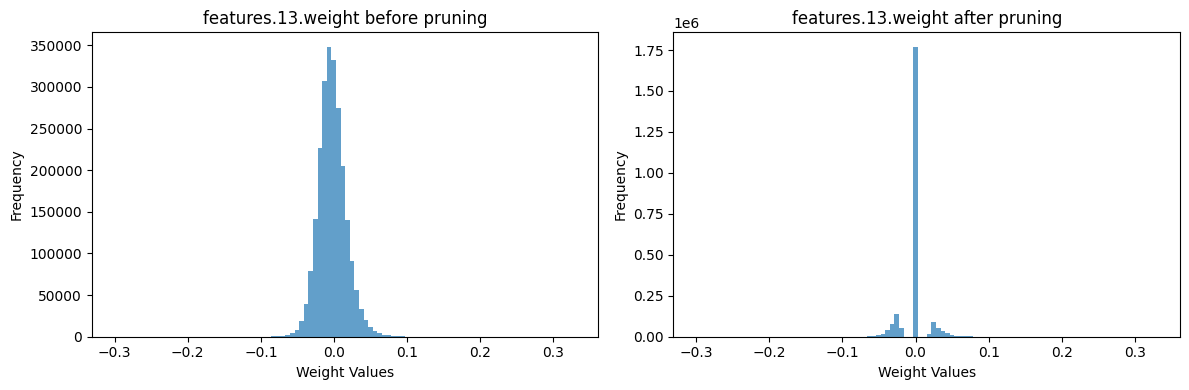

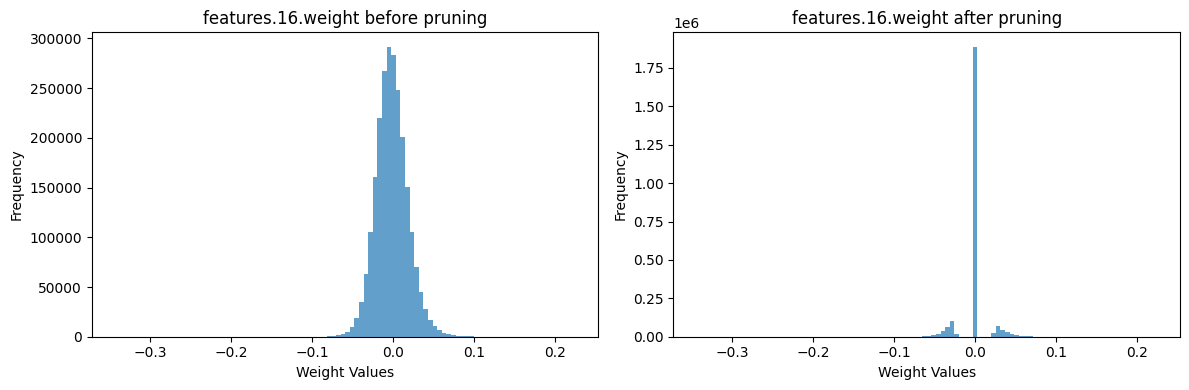

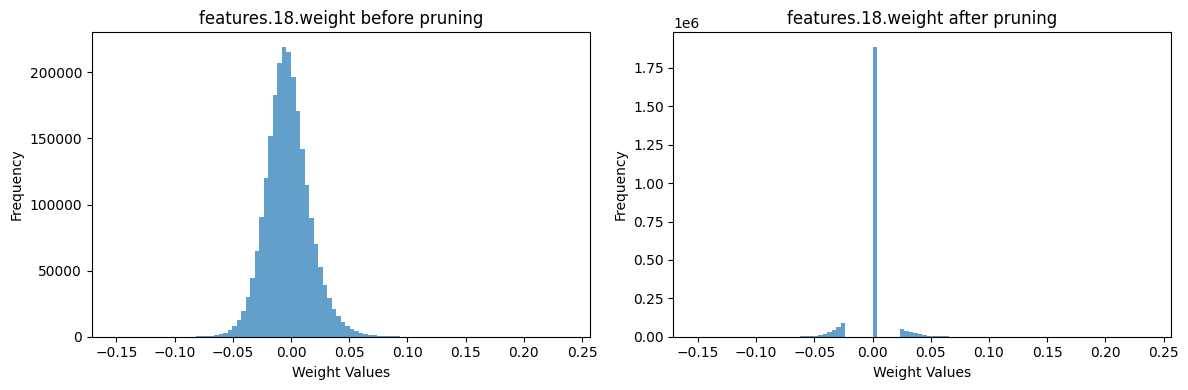

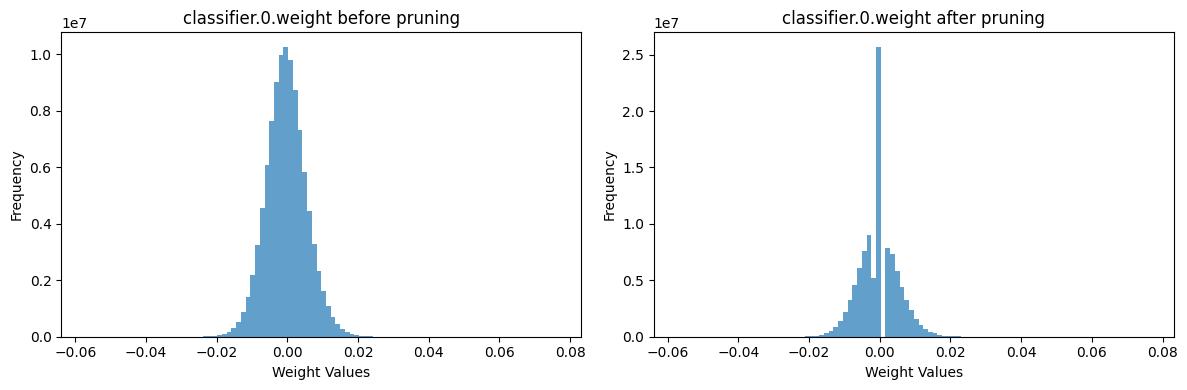

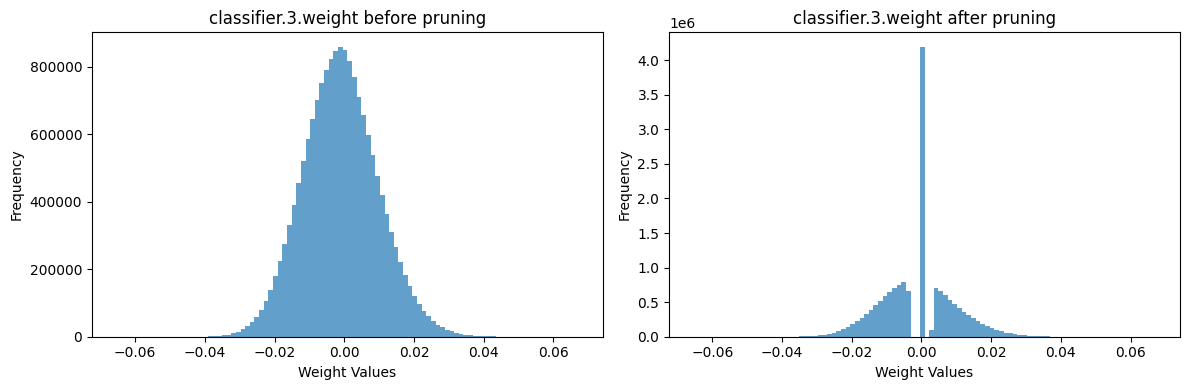

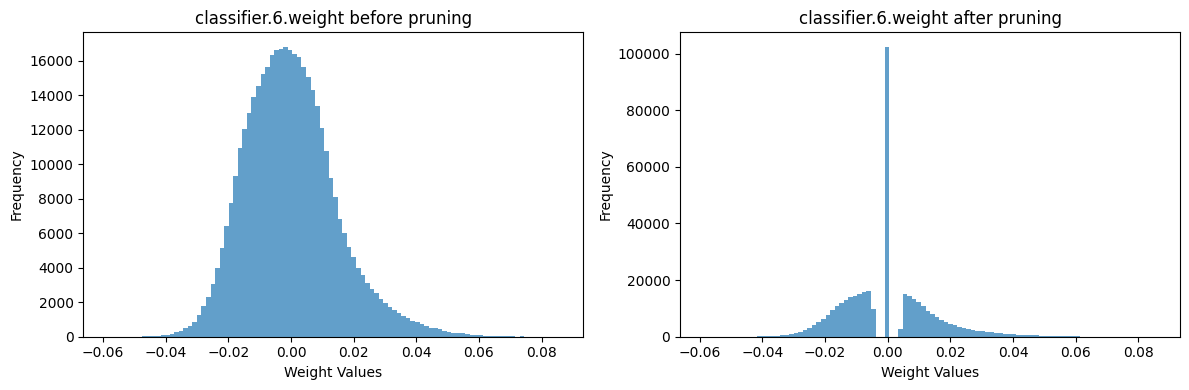

In [47]:
# Load the original model state as the baseline for "before pruning"
original_model = models.vgg11()
original_model.classifier[6] = torch.nn.Linear(4096, 100)  # Adjust for CIFAR-100 if applicable
original_model = original_model.to(device)

# Load the saved state dict into the original model
model_path = '/kaggle/input/original-vgg11/vgg11_finetuned.pth'
original_model.load_state_dict(torch.load(model_path))

# Make a pruned model copy for "after pruning"
pruned_model = copy.deepcopy(original_model)

# Define the sparsity dictionary
sparsity_dict = {
    'features.0.weight': 0.25,
    'features.3.weight': 0.35,
    'features.6.weight': 0.55,
    'features.8.weight': 0.65,
    'features.11.weight': 0.65,
    'features.13.weight': 0.75,
    'features.16.weight': 0.80,
    'features.18.weight': 0.80,
    'classifier.0.weight': 0.25,
    'classifier.3.weight': 0.25,
    'classifier.6.weight': 0.25
}

# Apply pruning to the pruned model
pruner = FineGrainedPruner(pruned_model, sparsity_dict)
pruner.apply(pruned_model)

# Plot weight distributions for each layer using the original model and pruned model
for layer_name in sparsity_dict.keys():
    # Get layer name and parameter type (weight or bias)
    module_name, param_type = layer_name.rsplit('.', 1)
    
    # Access the layers from the original and pruned models
    original_layer = dict(original_model.named_modules())[module_name]
    pruned_layer = dict(pruned_model.named_modules())[module_name]
    
    # Create subplots for before and after pruning
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the weight distribution before pruning (original model)
    plt.sca(axes[0])
    plot_before_after_distribution(original_layer, layer_name, before_pruning=True)
    
    # Plot the weight distribution after pruning (pruned model)
    plt.sca(axes[1])
    plot_before_after_distribution(pruned_layer, layer_name, before_pruning=False)
    
    # Show the plots for the current layer
    plt.tight_layout()
    plt.show()


In [48]:
# fine tuning pruned model:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
    
    
    


Finetuning Fine-grained Pruned Sparse Model


    Epoch 1 Accuracy 60.57% / Best Accuracy: 60.57%


    Epoch 2 Accuracy 68.01% / Best Accuracy: 68.01%


    Epoch 3 Accuracy 70.78% / Best Accuracy: 70.78%


    Epoch 4 Accuracy 69.87% / Best Accuracy: 70.78%


    Epoch 5 Accuracy 69.63% / Best Accuracy: 70.78%


In [49]:
# Load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])

# Calculate and print the size of the sparse model
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

# Evaluate the final accuracy of the sparse model
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fine-tuning")

# Save the pruned model to file
torch.save(model.state_dict(), "unstructure_pruned_vgg11.pth")
print("Pruned model saved as 'unstructure_pruned_vgg11.pth'")


Sparse model has size=352.12 MiB = 71.46% of dense model size


Sparse model has accuracy=70.78% after fine-tuning
Pruned model saved as 'structure_pruned_vgg11.pth'


In [ ]:
# # Save the pruned model
# torch.save(model.state_dict(), "structure_pruned_vgg11.pth")
# print("Pruned model saved as 'structure_pruned_vgg11.pth'")

In [ ]:

# model = models.vgg11(pretrained=False) 
# model.classifier[6] = nn.Linear(4096, 100)  
# model.to(device)  

# # Step 2: Load the saved state dictionary
# model_save_path = 'vgg11_finetuned.pth'
# model.load_state_dict(torch.load(model_save_path))
# print("Model loaded successfully.")



In [139]:
# # Step 7: Perform sensitivity analysis with a list of sparsity ratios
# sparsity_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]  # Adjust values as needed

# # Get the accuracy results for each layer at different sparsity levels
# layer_sensitivity = sensitivity_analysis(model, sparsity_ratios, validation_loader,device)
# print(layer_sensitivity)


/tmp/ipykernel_30/1651875013.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg11_finetuned.pth', map_location=device))


{'features.0': [7.53, 7.75, 7.7, 6.59, 6.05], 'features.3': [7.76, 7.35, 6.73, 6.17, 5.28], 'features.6': [7.34, 6.81, 4.48, 4.29, 4.06], 'features.8': [6.32, 2.98, 3.69, 3.17, 2.78], 'features.11': [7.89, 7.12, 7.38, 7.11, 5.11], 'features.13': [7.85, 7.86, 6.8, 5.02, 4.45], 'features.16': [7.51, 7.71, 7.1, 6.65, 4.87], 'features.18': [7.89, 8.16, 8.4, 7.58, 5.91], 'classifier.0': [8.19, 7.78, 7.92, 7.7, 7.47], 'classifier.3': [7.7, 7.43, 7.1, 7.24, 7.08], 'classifier.6': [7.34, 6.2, 5.85, 5.85, 4.56]}


In [140]:
# layer_sparsity = {
#     'features.0': 0.3,    # Accuracy drops at 0.4 sparsity, stable up to 30%
#     'features.3': 0.3,    # Can handle up to 30% pruning (40% accuracy at 0.3 sparsity)
#     'features.6': 0.3,    # Stable up to 30%, sharp drop after that
#     'features.8': 0.3,    # Can tolerate up to 30%, sharp drop after that
#     'features.11': 0.3,   # Stable up to 30%, sharp drop at higher sparsity
#     'features.13': 0.3,   # Can tolerate 30% pruning, accuracy drops at higher sparsity
#     'features.16': 0.4,   # Tolerant, can prune up to 40% without significant drop
#     'features.18': 0.3,   # Stable up to 30%, slight drop beyond that
#     'classifier.0': 0.2,  # Sensitive, prune up to 20% before accuracy drops
#     'classifier.3': 0.4,  # Stable, can handle up to 40% pruning
#     'classifier.6': 0.4   # Tolerant up to 40%, slight drop at 0.5 sparsity
# }

# # Apply pruning with these ratios
# prune_model(model, layer_sparsity,device)
# torch.save(model.state_dict(), 'testing_unstructed_pruned_model.pth')


/tmp/ipykernel_30/3665782953.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg11_finetuned.pth', map_location=device))



Layer: features.0
Remaining weights: 1215, Total weights: 1728
Percentage remaining: 70.31%
Percentage pruned: 29.69%


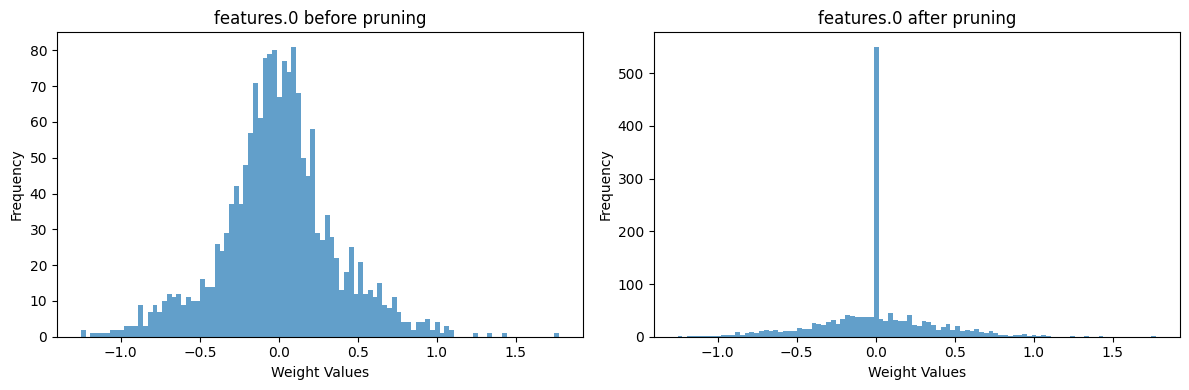

/tmp/ipykernel_30/3665782953.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg11_finetuned.pth', map_location=device))



Layer: features.3
Remaining weights: 51264, Total weights: 73728
Percentage remaining: 69.53%
Percentage pruned: 30.47%


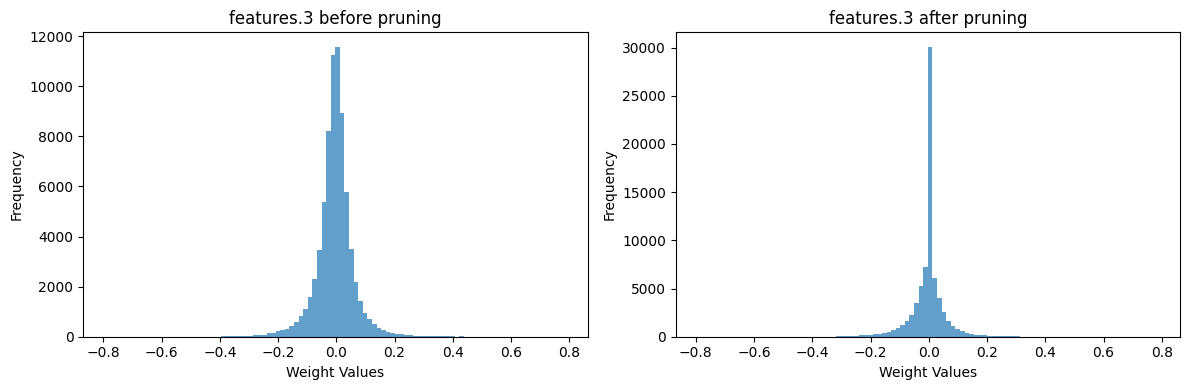


Layer: features.6
Remaining weights: 206208, Total weights: 294912
Percentage remaining: 69.92%
Percentage pruned: 30.08%


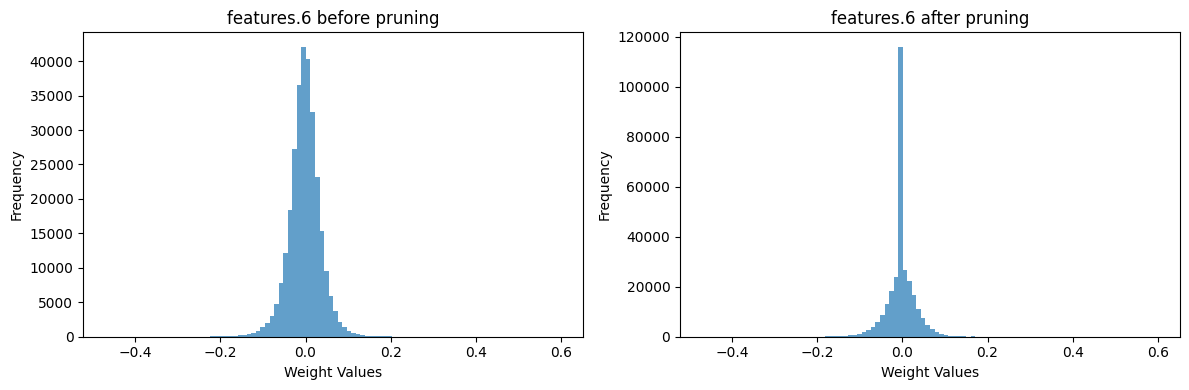


Layer: features.8
Remaining weights: 412416, Total weights: 589824
Percentage remaining: 69.92%
Percentage pruned: 30.08%


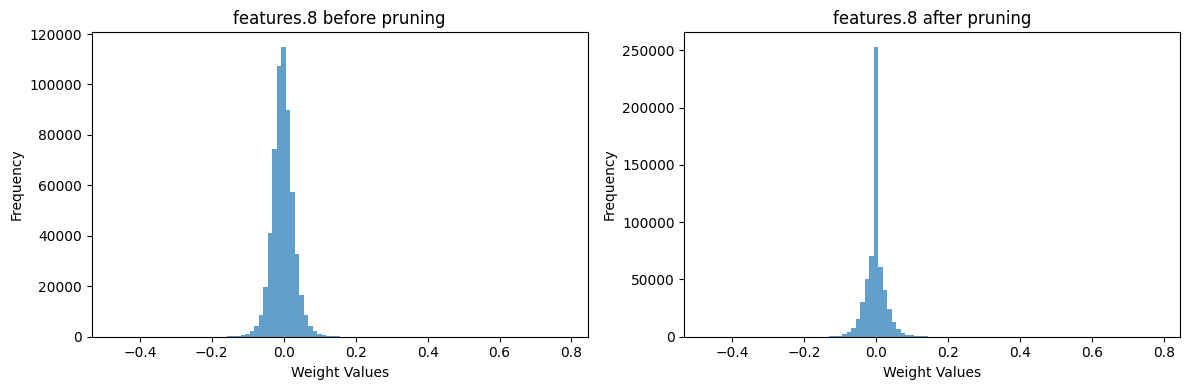


Layer: features.11
Remaining weights: 824832, Total weights: 1179648
Percentage remaining: 69.92%
Percentage pruned: 30.08%


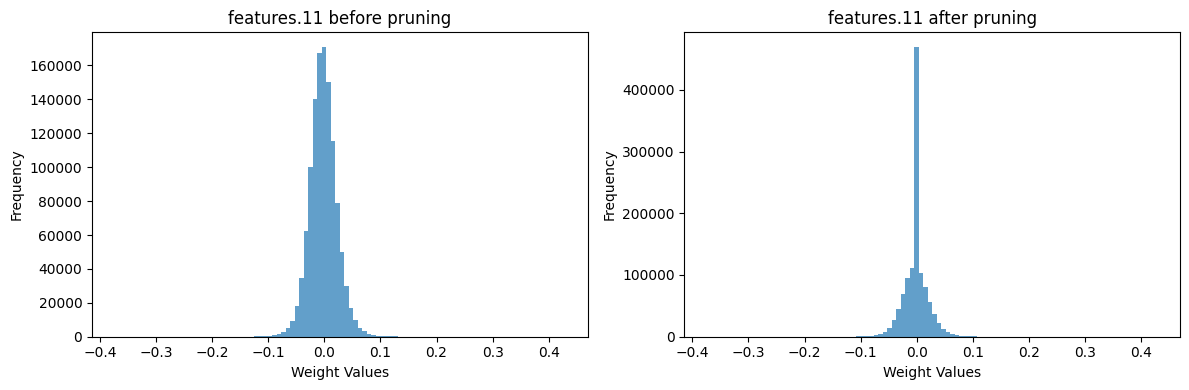


Layer: features.13
Remaining weights: 1649664, Total weights: 2359296
Percentage remaining: 69.92%
Percentage pruned: 30.08%


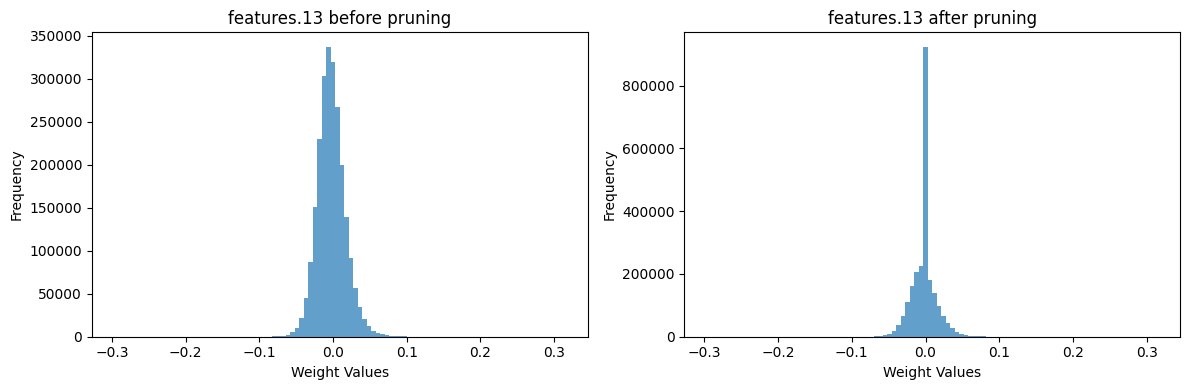


Layer: features.16
Remaining weights: 1414656, Total weights: 2359296
Percentage remaining: 59.96%
Percentage pruned: 40.04%


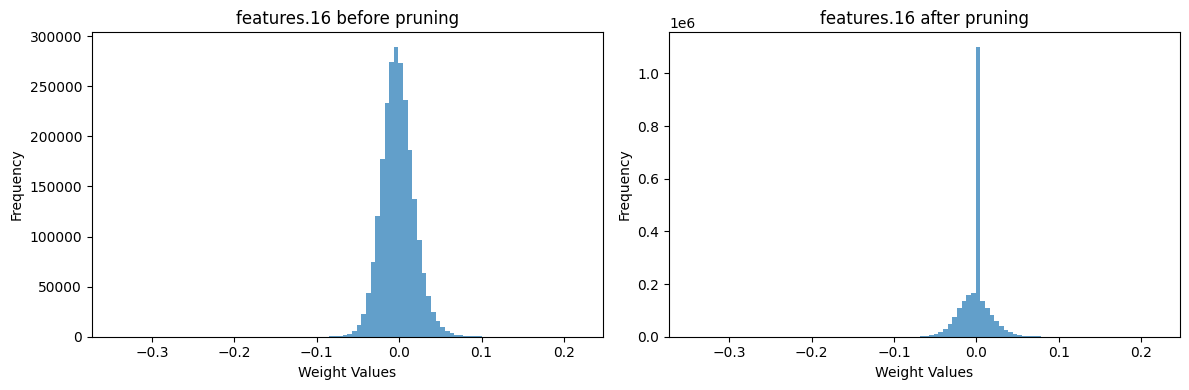


Layer: features.18
Remaining weights: 1649664, Total weights: 2359296
Percentage remaining: 69.92%
Percentage pruned: 30.08%


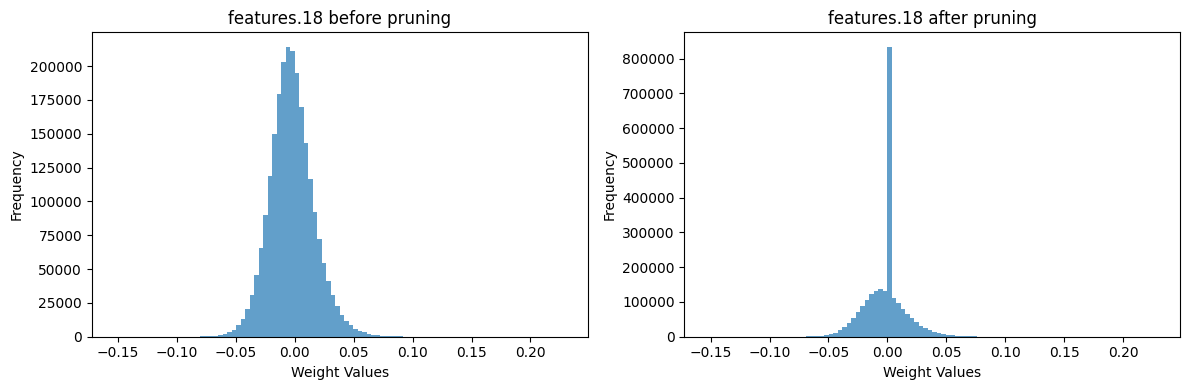


Layer: classifier.0
Remaining weights: 82213376, Total weights: 102760448
Percentage remaining: 80.00%
Percentage pruned: 20.00%


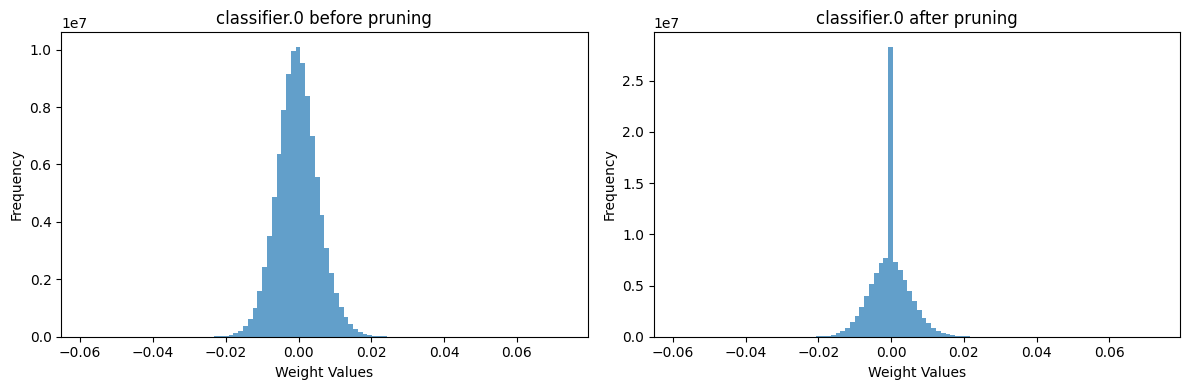


Layer: classifier.3
Remaining weights: 10067968, Total weights: 16777216
Percentage remaining: 60.01%
Percentage pruned: 39.99%


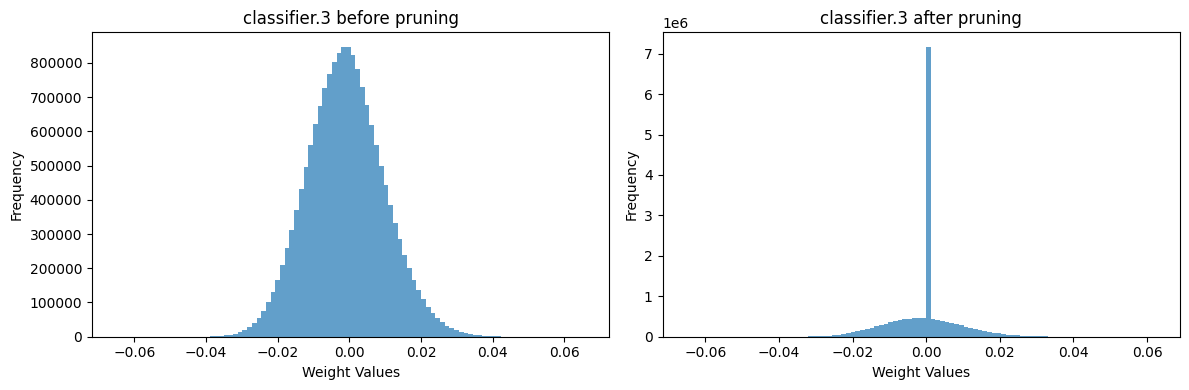


Layer: classifier.6
Remaining weights: 245760, Total weights: 409600
Percentage remaining: 60.00%
Percentage pruned: 40.00%


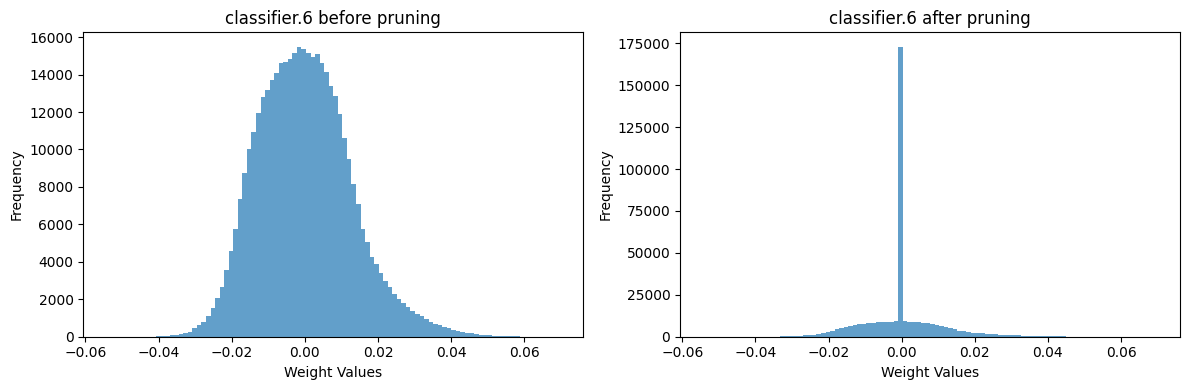

In [143]:
# import matplotlib.pyplot as plt

# def plot_before_after_distribution(layer, layer_name, before_pruning=True):
#     weights = layer.weight.data.cpu().numpy().flatten()
#     plt.hist(weights, bins=100, alpha=0.7)
#     title = f"{layer_name} {'before' if before_pruning else 'after'} pruning"
#     plt.title(title)
#     plt.xlabel("Weight Values")
#     plt.ylabel("Frequency")

# # Load the original model state to reset weights before each layer's pruning
# model.load_state_dict(torch.load('vgg11_finetuned.pth', map_location=device))

# # Step 1: Capture and display weight distributions for all layers before and after pruning
# for layer_name, sparsity in layer_sparsity.items():
#     # Get the layer object from the model using the layer name
#     layer = dict(model.named_modules())[layer_name]

#     # Create subplots for before and after pruning
#     fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#     # Plot the weight distribution before pruning
#     plt.sca(axes[0])  # Set the current axis to the first subplot
#     plot_before_after_distribution(layer, layer_name, before_pruning=True)

#     # Apply pruning to this specific layer
#     prune_weights(layer, sparsity, device)  # Apply the specified sparsity level

#     # After pruning, calculate the number of remaining and pruned weights
#     remaining_weights = torch.count_nonzero(layer.weight.data).item()
#     total_weights = layer.weight.numel()
#     pruned_weights = total_weights - remaining_weights
#     percentage_remaining = remaining_weights / total_weights * 100
#     percentage_pruned = pruned_weights / total_weights * 100

#     print(f"\nLayer: {layer_name}")
#     print(f"Remaining weights: {remaining_weights}, Total weights: {total_weights}")
#     print(f"Percentage remaining: {percentage_remaining:.2f}%")
#     print(f"Percentage pruned: {percentage_pruned:.2f}%")

#     # Plot the weight distribution after pruning
#     plt.sca(axes[1])  # Set the current axis to the second subplot
#     plot_before_after_distribution(layer, layer_name, before_pruning=False)

#     # Show the plots for the current layer
#     plt.tight_layout()
#     plt.show()

#     # Reset the model to the original state for the next layer
#     model.load_state_dict(torch.load('vgg11_finetuned.pth', map_location=device))

In [144]:
# # Function to count total weights in the model
# def count_total_weights(model):
#     total_weights = 0
#     layer_weights = {}
#     for name, layer in model.named_modules():
#         if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
#             num_weights = layer.weight.numel()
#             total_weights += num_weights
#             layer_weights[name] = num_weights
#     return total_weights, layer_weights

# # L2-norm-based pruning function
# def prune_weights_l2_norm(layer, sparsity_ratio, device):
#     with torch.no_grad():
#         if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
#             # Flatten the weights
#             weight_flattened = layer.weight.view(-1)
#             # Calculate the L2 norm of the weights (absolute values)
#             l2_norms = torch.abs(weight_flattened)

#             # Determine the threshold for pruning based on the sparsity ratio
#             threshold = np.percentile(l2_norms.cpu().numpy(), sparsity_ratio * 100)
            
#             # Apply a mask to zero out weights smaller than the threshold
#             mask = l2_norms >= threshold
#             weight_flattened *= mask
#             layer.weight.data = weight_flattened.view_as(layer.weight).to(device)

# # Function to plot weight distribution before and after pruning
# def plot_before_after_distribution(layer, layer_name, before_pruning=True):
#     weights = layer.weight.data.cpu().numpy().flatten()
#     plt.hist(weights, bins=100, alpha=0.7)
#     title = f"{layer_name} {'before' if before_pruning else 'after'} pruning"
#     plt.title(title)
#     plt.xlabel("Weight Values")
#     plt.ylabel("Frequency")

# # Pruning function using hardcoded ratios
# def prune_model_by_hardcoded_ratios(model, sorted_prune_layers, target_pruned_weights, total_weights, device):
#     total_pruned = 0  # Track total pruned weights
#     for layer_name, prune_percentage in sorted_prune_layers:
#         layer = dict(model.named_modules())[layer_name]
#         num_weights = layer.weight.numel()  # Total weights in the layer

#         # Plot before pruning
#         fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#         plt.sca(axes[0])
#         plot_before_after_distribution(layer, layer_name, before_pruning=True)

#         # Calculate remaining pruning needed to reach exactly 25% of total model weights
#         remaining_pruning_needed = target_pruned_weights - total_pruned

#         # Calculate how many weights to prune for this layer (either the full percentage or the remaining needed)
#         prune_this_layer = min(int(num_weights * prune_percentage), remaining_pruning_needed)

#         # Perform the L2-norm-based pruning with the calculated number of weights
#         prune_weights_l2_norm(layer, prune_this_layer / num_weights, device)

#         # Update the total number of pruned weights
#         total_pruned += prune_this_layer

#         # Calculate and print remaining weights for the layer and overall
#         remaining_weights_layer = num_weights - prune_this_layer
#         remaining_weights_total = total_weights - total_pruned
#         print(f"Layer: {layer_name}")
#         print(f"Pruned {prune_this_layer} weights from {layer_name}")
#         print(f"Remaining weights in layer: {remaining_weights_layer}/{num_weights}")
#         print(f"Total pruned so far: {total_pruned}/{target_pruned_weights}")
#         print(f"Remaining weights in model: {remaining_weights_total}/{total_weights}\n")

#         # Plot after pruning
#         plt.sca(axes[1])
#         plot_before_after_distribution(layer, layer_name, before_pruning=False)

#         # Show the plots for the current layer
#         plt.tight_layout()
#         plt.show()

#         # Stop pruning if we've pruned exactly 25% of total weights
#         if total_pruned >= target_pruned_weights:
#             break


/tmp/ipykernel_30/1144615032.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vgg11_finetuned.pth', map_location=device))


Layer: features.16
Pruned 1179648 weights from features.16
Remaining weights in layer: 1179648/2359296
Total pruned so far: 1179648/32291248
Remaining weights in model: 127985344/129164992



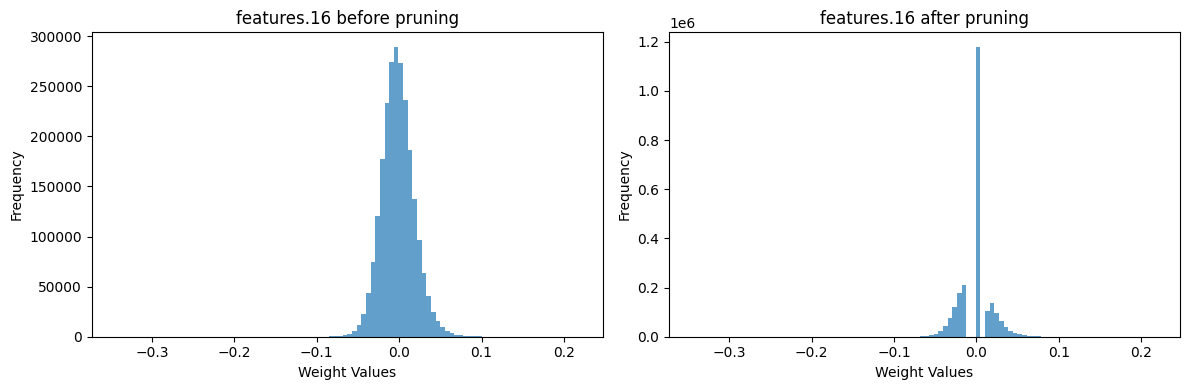

Layer: classifier.3
Pruned 8388608 weights from classifier.3
Remaining weights in layer: 8388608/16777216
Total pruned so far: 9568256/32291248
Remaining weights in model: 119596736/129164992



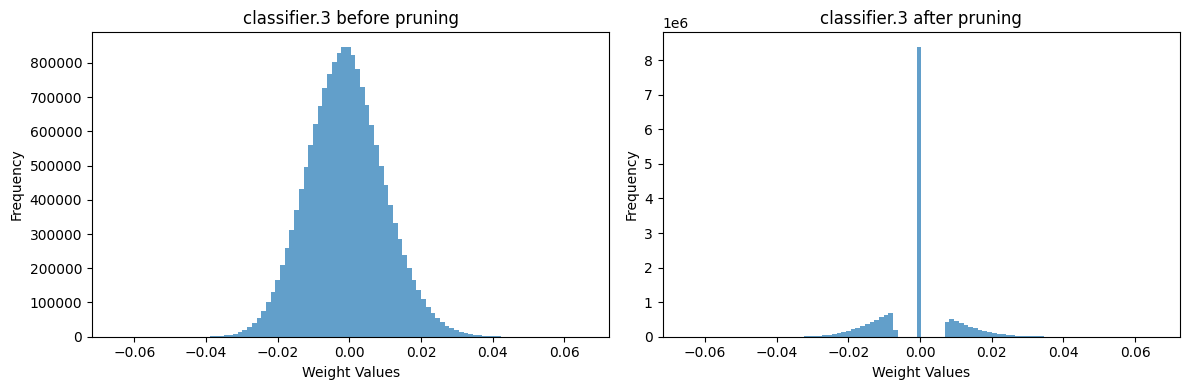

Layer: classifier.6
Pruned 163840 weights from classifier.6
Remaining weights in layer: 245760/409600
Total pruned so far: 9732096/32291248
Remaining weights in model: 119432896/129164992



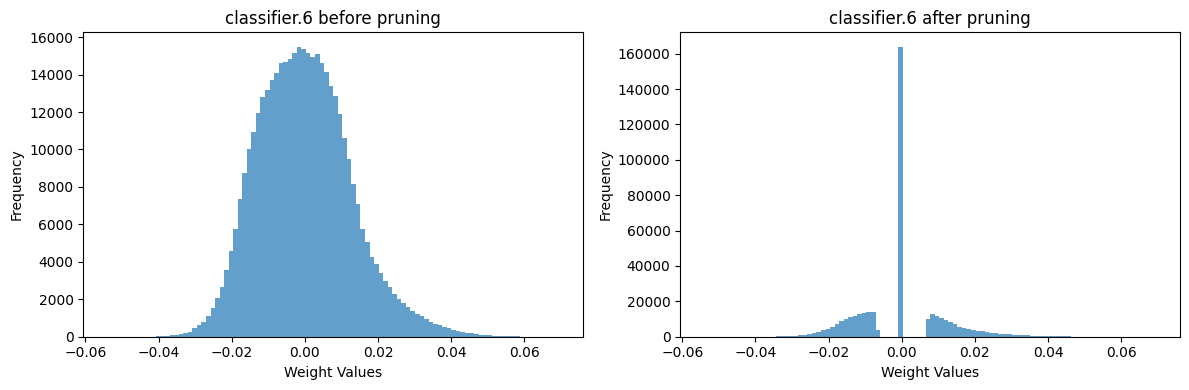

Layer: features.6
Pruned 88473 weights from features.6
Remaining weights in layer: 206439/294912
Total pruned so far: 9820569/32291248
Remaining weights in model: 119344423/129164992



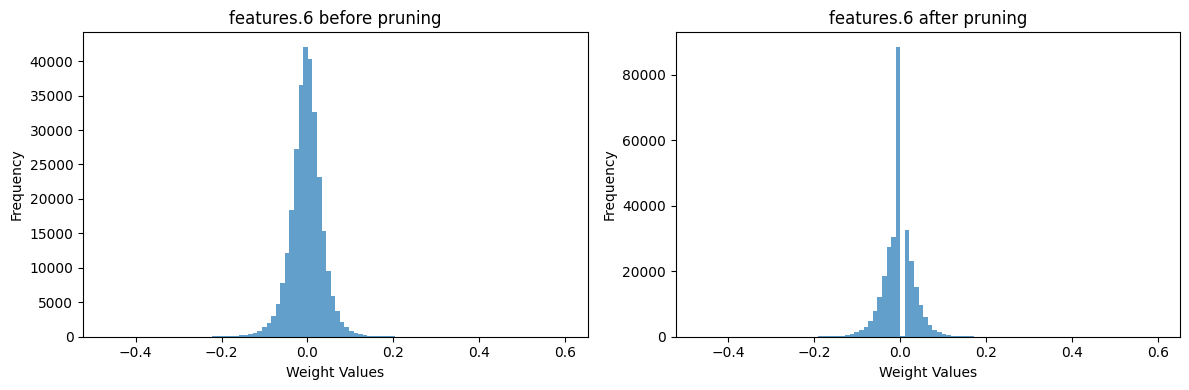

Layer: features.13
Pruned 707788 weights from features.13
Remaining weights in layer: 1651508/2359296
Total pruned so far: 10528357/32291248
Remaining weights in model: 118636635/129164992



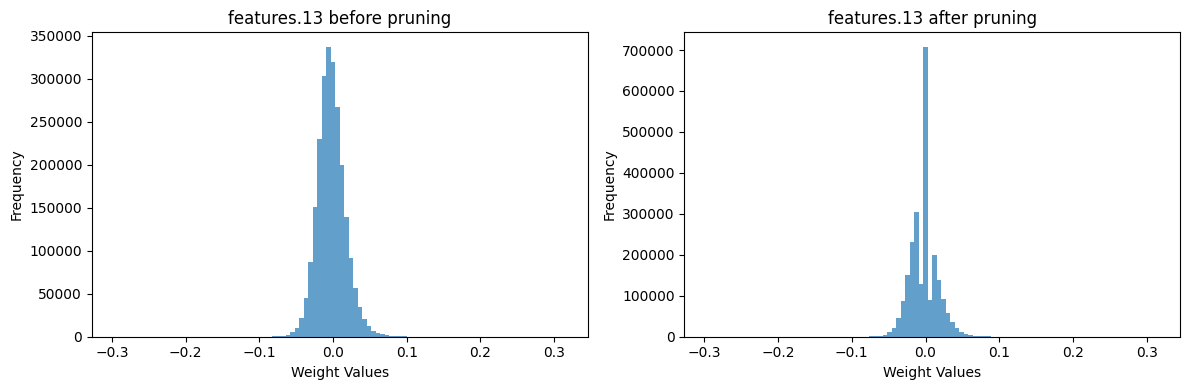

Layer: features.18
Pruned 707788 weights from features.18
Remaining weights in layer: 1651508/2359296
Total pruned so far: 11236145/32291248
Remaining weights in model: 117928847/129164992



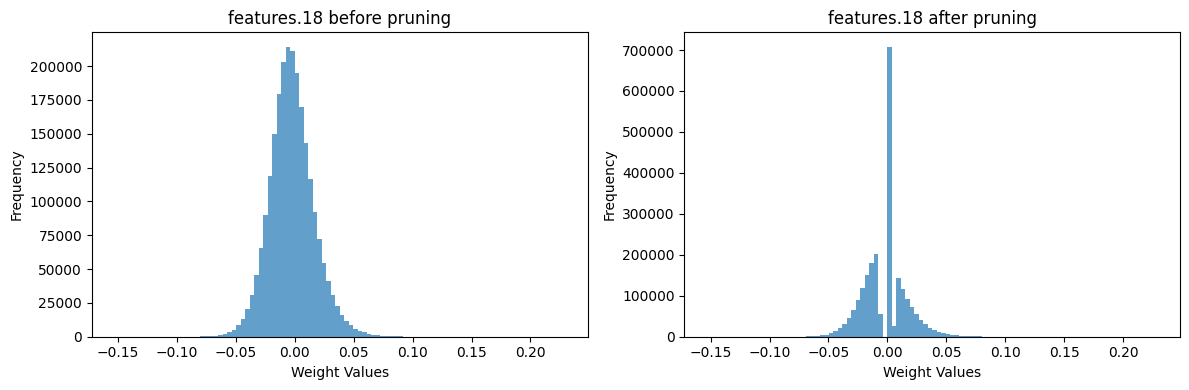

Layer: features.0
Pruned 345 weights from features.0
Remaining weights in layer: 1383/1728
Total pruned so far: 11236490/32291248
Remaining weights in model: 117928502/129164992



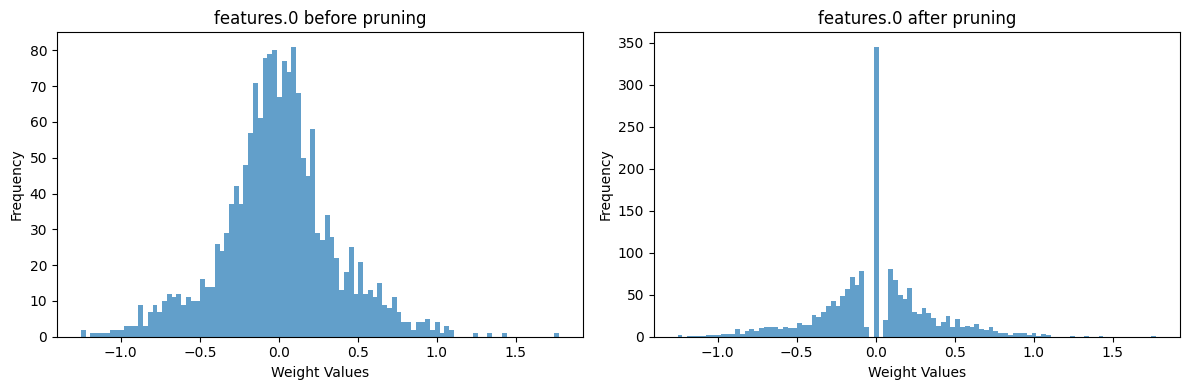

Layer: features.8
Pruned 117964 weights from features.8
Remaining weights in layer: 471860/589824
Total pruned so far: 11354454/32291248
Remaining weights in model: 117810538/129164992



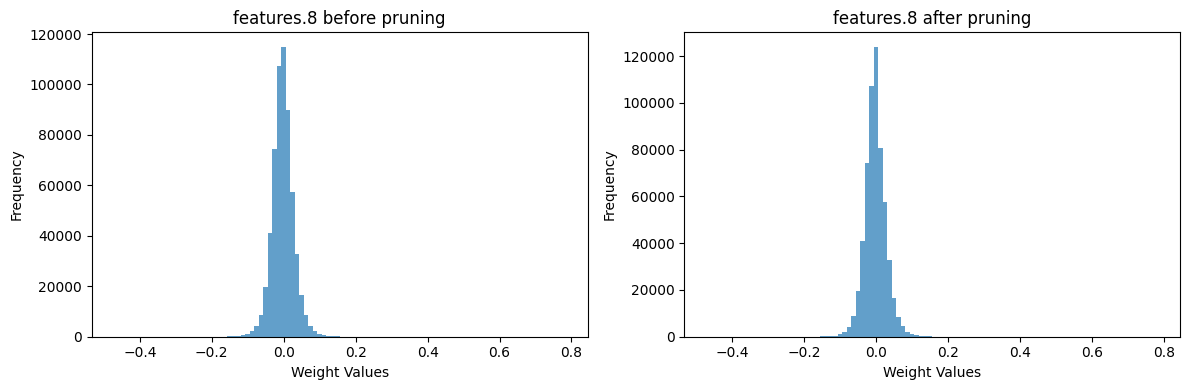

Layer: classifier.0
Pruned 20552089 weights from classifier.0
Remaining weights in layer: 82208359/102760448
Total pruned so far: 31906543/32291248
Remaining weights in model: 97258449/129164992



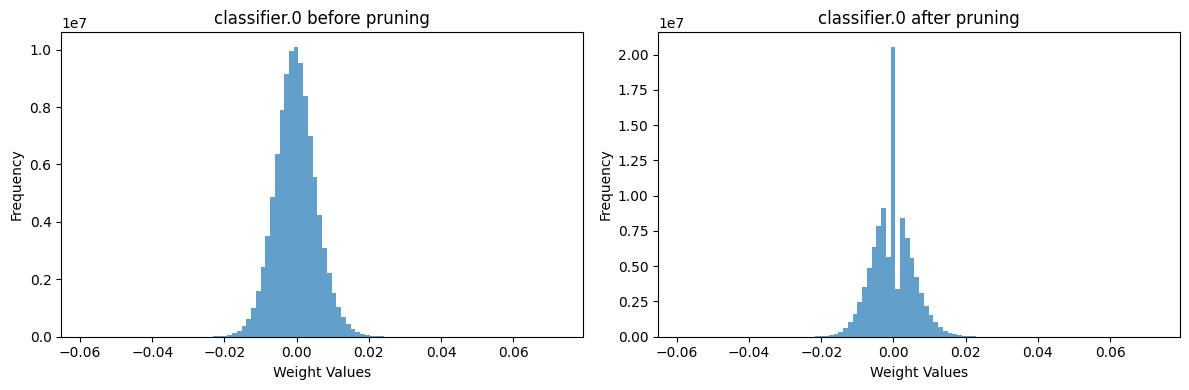

Layer: features.3
Pruned 7372 weights from features.3
Remaining weights in layer: 66356/73728
Total pruned so far: 31913915/32291248
Remaining weights in model: 97251077/129164992



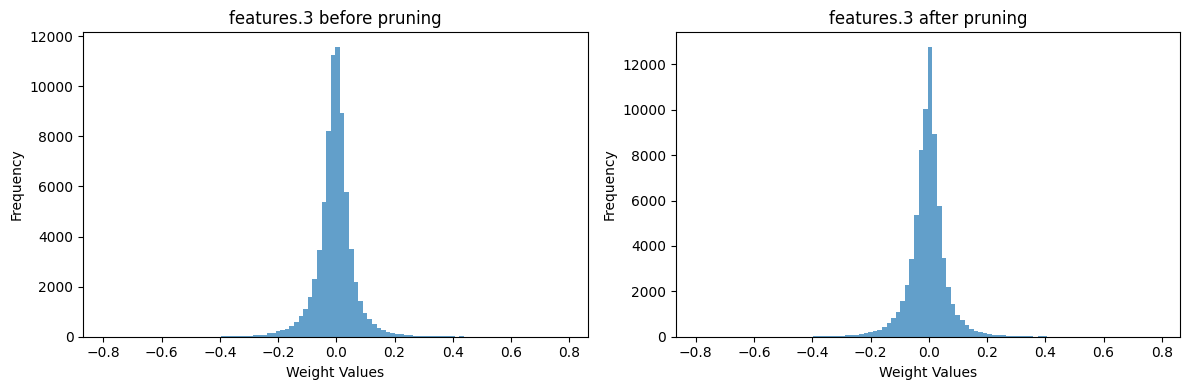

Layer: features.11
Pruned 117964 weights from features.11
Remaining weights in layer: 1061684/1179648
Total pruned so far: 32031879/32291248
Remaining weights in model: 97133113/129164992



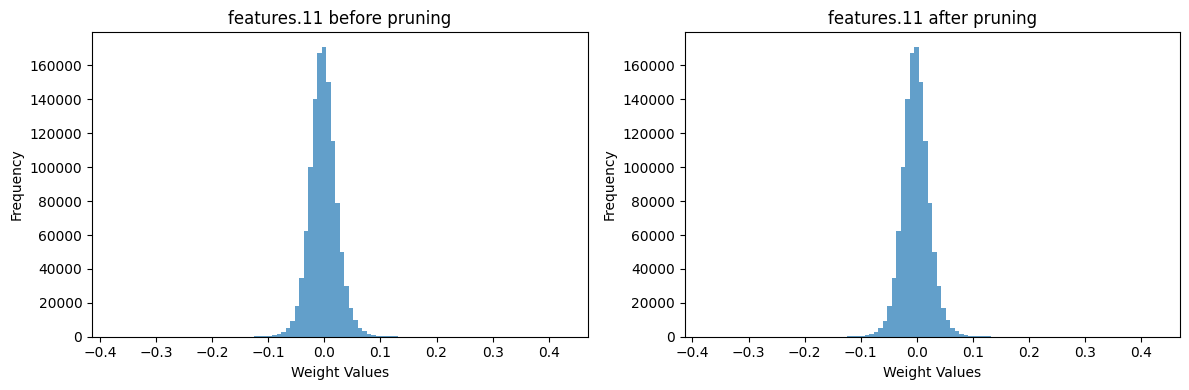

Pruned model saved as 'pruned_model_25_percent_full.pth'


In [146]:
# # Reload the original model state before pruning
# model.load_state_dict(torch.load('vgg11_finetuned.pth', map_location=device))

# # Define the pruning dictionary
# prune_from_each_layer = {'features.0': .20, 
#                          'features.3': .10, 
#                          'features.6': .30, 
#                          'features.8': .20, 
#                          'features.11': .10, 
#                          'features.13': .30, 
#                          'features.16': .50, 
#                          'features.18': .30, 
#                          'classifier.0': .20, 
#                          'classifier.3': .50, 
#                          'classifier.6': .40}

# # Sort the dictionary in descending order based on the percentage of weights to prune
# sorted_prune_layers = sorted(prune_from_each_layer.items(), key=lambda x: x[1], reverse=True)

# # Calculate total number of weights in the model
# total_weights, layer_weights = count_total_weights(model)
# target_pruned_weights = int(total_weights * 0.25)  # Target is to prune 25% of the model's weights

# # Start the pruning process
# prune_model_by_hardcoded_ratios(model, sorted_prune_layers, target_pruned_weights, total_weights, device)

# # # Save the entire pruned model
# # torch.save(model, 'pruned_model_25_percent_full.pth')
# # print("Pruned model saved as 'pruned_model_25_percent_full.pth'")


In [ ]:
# # Load the pruned model
# # pruned_model = torch.load('pruned_model_25_percent_full.pth')
# # pruned_model.to(device)
# # print("Pruned model loaded successfully.")


# # Evaluate the model
# fine_tune_model(model, trainloader, testloader, epochs=5)
# print(f'Accuracy of the pruned model: {accuracy:.2f}%')
# # Save the entire pruned model
# torch.save(model, 'pruned_model_25_percent_full.pth')
# print("Pruned model saved as 'pruned_model_25_percent_full.pth'")

# Structred Pruning task1.2

In [17]:
# Define the VGG-11 model without batch normalization
model = models.vgg11()
model.classifier[6] = torch.nn.Linear(4096, 100)  # Adjust for CIFAR-100 if applicable
model = model.to(device)


# Load the saved state dict into the model
model_path = '/kaggle/input/original-vgg11/vgg11_finetuned.pth'
model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_30/214334294.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [18]:
from torchvision import datasets, transforms, models

# Define per-layer pruning ratios
layer_sparsity = [0.85, 0.6, 0.75, 0.75, 0.95, 0.85, 0.75, 0.85]

# Utility function to calculate total parameters
def calculate_total_params(model):
    return sum(p.numel() for p in model.parameters())

# Prune convolutional layers and adjust batch normalization
def prune_conv_layer(model, layer_idx, sparsity_ratio):
    layers = list(model.features)
    conv_indices = [i for i, layer in enumerate(layers) if isinstance(layer, nn.Conv2d)]
    conv_idx = conv_indices[layer_idx]
    conv_layer = layers[conv_idx]

    weight = conv_layer.weight.data.abs().mean(dim=(1, 2, 3))
    num_filters = weight.size(0)
    num_prune = int(sparsity_ratio * num_filters)

    if num_prune == 0:
        return None

    # Identify filters to keep
    prune_indices = torch.topk(weight, num_prune, largest=False).indices.cpu()
    keep_indices = [i for i in range(num_filters) if i not in prune_indices]

    # Create new Conv2D layer with pruned filters
    new_conv = nn.Conv2d(
        in_channels=conv_layer.in_channels,
        out_channels=len(keep_indices),
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        bias=(conv_layer.bias is not None)
    ).to(device)

    new_conv.weight.data = conv_layer.weight.data[keep_indices].clone()
    if conv_layer.bias is not None:
        new_conv.bias.data = conv_layer.bias.data[keep_indices].clone()

    # Replace the original convolutional layer
    layers[conv_idx] = new_conv

    # Adjust BatchNorm layer if present
    next_idx = conv_idx + 1
    if next_idx < len(layers) and isinstance(layers[next_idx], nn.BatchNorm2d):
        bn_layer = layers[next_idx]
        new_bn = nn.BatchNorm2d(len(keep_indices)).to(device)
        new_bn.weight.data = bn_layer.weight.data[keep_indices].clone()
        new_bn.bias.data = bn_layer.bias.data[keep_indices].clone()
        new_bn.running_mean = bn_layer.running_mean[keep_indices].clone()
        new_bn.running_var = bn_layer.running_var[keep_indices].clone()
        layers[next_idx] = new_bn

    # Update the model features
    model.features = nn.Sequential(*layers)
    return keep_indices

# Adjust the next Conv2D layer to match pruned input channels
def adjust_next_conv_layer(model, layer_idx, filters_to_keep):
    if filters_to_keep is None:
        return

    layers = list(model.features)
    conv_indices = [i for i, layer in enumerate(layers) if isinstance(layer, nn.Conv2d)]
    if layer_idx + 1 >= len(conv_indices):
        return

    next_conv_idx = conv_indices[layer_idx + 1]
    next_conv_layer = layers[next_conv_idx]

    new_in_channels = len(filters_to_keep)
    new_conv = nn.Conv2d(
        in_channels=new_in_channels,
        out_channels=next_conv_layer.out_channels,
        kernel_size=next_conv_layer.kernel_size,
        stride=next_conv_layer.stride,
        padding=next_conv_layer.padding,
        dilation=next_conv_layer.dilation,
        bias=(next_conv_layer.bias is not None)
    ).to(device)

    new_conv.weight.data = next_conv_layer.weight.data[:, filters_to_keep].clone()
    if next_conv_layer.bias is not None:
        new_conv.bias.data = next_conv_layer.bias.data.clone()

    layers[next_conv_idx] = new_conv

    # Update the model features
    model.features = nn.Sequential(*layers)

# Adjust fully connected layers after pruning
def adjust_fc_layer(model, last_conv_channels, spatial_size):
    model.classifier[0] = nn.Linear(last_conv_channels * spatial_size * spatial_size, model.classifier[0].out_features).to(device)

# Determine spatial size after average pooling
def get_spatial_size(model):
    model_features = nn.Sequential(*(list(model.features) + [model.avgpool]))
    with torch.no_grad():
        dummy_input = torch.zeros(1, 3, 32, 32).to(device)
        output = model_features(dummy_input)
        spatial_size = output.size(-1)
    return spatial_size

# Perform pruning
model_pruned = copy.deepcopy(model).to(device)
last_conv_channels = None

for idx, sparsity_ratio in enumerate(layer_sparsity):
    filters_to_keep = prune_conv_layer(model_pruned, idx, sparsity_ratio)
    adjust_next_conv_layer(model_pruned, idx, filters_to_keep)
    if filters_to_keep is not None:
        last_conv_channels = len(filters_to_keep)

# Adjust the fully connected layer based on pruning results
spatial_size = get_spatial_size(model_pruned)
adjust_fc_layer(model_pruned, last_conv_channels, spatial_size)

# Summary of pruned model
total_params_before = calculate_total_params(model)
total_params_after = calculate_total_params(model_pruned)
print(f"Total parameters before pruning: {total_params_before}")
print(f"Total parameters after pruning: {total_params_after}")
print(f"Actual overall sparsity: {(total_params_before - total_params_after) / total_params_before * 100:.2f}%")
summary(model_pruned, input_size=(1, 3, 32, 32))

# Evaluate the pruned model
@torch.inference_mode()
def evaluate(model, dataloader):
    model.eval()
    num_correct = 0
    num_samples = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        num_correct += (preds == targets).sum().item()
        num_samples += targets.size(0)
    return num_correct / num_samples * 100




Total parameters before pruning: 129176036
Total parameters after pruning: 32931982
Actual overall sparsity: 74.51%


In [19]:
import torch
import torch.nn as nn
import copy

# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(in_channels):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight, p=2)  # Use L2 norm for stability
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # Do not modify the original model
    # Fetch all Conv2d and BatchNorm2d layers from model.features
    all_convs = [m for m in model.features if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.features if isinstance(m, nn.BatchNorm2d)]

    bn_idx = 0  # Separate index for batch normalization layers
    for i_conv in range(len(all_convs) - 1):
        prev_conv = all_convs[i_conv]
        next_conv = all_convs[i_conv + 1]

        # Only fetch the BN layer if there is one available for this Conv layer
        prev_bn = all_bns[bn_idx] if bn_idx < len(all_bns) else None

        # Compute importance of output channels based on next Conv layer's input channels
        importance = get_input_channel_importance(next_conv.weight)
        # Sort from large to small importance
        sort_idx = torch.argsort(importance, descending=True)

        # Apply sorting to previous Conv layer's output channels
        prev_conv.weight.data.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))

        # Apply sorting to the corresponding BatchNorm layer if it exists
        if prev_bn is not None:
            for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
                tensor_to_apply = getattr(prev_bn, tensor_name)
                tensor_to_apply.data.copy_(torch.index_select(tensor_to_apply.detach(), 0, sort_idx))
            bn_idx += 1  # Move to the next BatchNorm layer

        # Apply sorting to the next Conv layer’s input channels
        next_conv.weight.data.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))

    return model

# # Testing the model before and after sorting
# print('Before sorting...')
# dense_model_accuracy = evaluate(model, dataloader['test'])
# print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

# print('After sorting...')
# sorted_model = apply_channel_sorting(model)
# sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
# print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")


Before sorting...
dense model has accuracy=74.12%
After sorting...
sorted model has accuracy=5.31%


In [20]:
import torch
import torch.nn as nn
import copy

# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(in_channels):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight, p=2)  # Use L2 norm for stability
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # Do not modify the original model
    # Fetch all Conv2d and BatchNorm2d layers from model.features
    all_convs = [m for m in model.features if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.features if isinstance(m, nn.BatchNorm2d)]

    bn_idx = 0  # Separate index for batch normalization layers
    for i_conv in range(len(all_convs) - 1):
        prev_conv = all_convs[i_conv]
        next_conv = all_convs[i_conv + 1]

        # Only fetch the BN layer if there is one available for this Conv layer
        prev_bn = all_bns[bn_idx] if bn_idx < len(all_bns) else None

        # Compute importance of output channels based on next Conv layer's input channels
        importance = get_input_channel_importance(next_conv.weight)
        # Sort from large to small importance
        sort_idx = torch.argsort(importance, descending=True)

        # Apply sorting to previous Conv layer's output channels
        prev_conv.weight.data.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))

        # Apply sorting to the corresponding BatchNorm layer if it exists
        if prev_bn is not None:
            for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
                tensor_to_apply = getattr(prev_bn, tensor_name)
                tensor_to_apply.data.copy_(torch.index_select(tensor_to_apply.detach(), 0, sort_idx))
            bn_idx += 1  # Move to the next BatchNorm layer

        # Apply sorting to the next Conv layer’s input channels
        next_conv.weight.data.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))

    return model


In [21]:
# Define per-layer pruning ratios
layer_sparsity = [0.25, 0.35, 0.45, 0.45, 0.35, 0.45, 0.35, 0.28]

# Pruning without sorting
print(" * Without sorting...")
pruned_model = copy.deepcopy(model).to(device)

# Apply pruning on convolutional layers without sorting
last_conv_channels = None
for idx, sparsity_ratio in enumerate(layer_sparsity):
    filters_to_keep = prune_conv_layer(pruned_model, idx, sparsity_ratio)
    adjust_next_conv_layer(pruned_model, idx, filters_to_keep)
    if filters_to_keep is not None:
        last_conv_channels = len(filters_to_keep)

# Adjust fully connected layers
spatial_size = get_spatial_size(pruned_model)
adjust_fc_layer(pruned_model, last_conv_channels, spatial_size)

# Evaluate accuracy after pruning without sorting
pruned_model_accuracy = evaluate(pruned_model, test_loader)
print(f"Pruned model has accuracy without sorting: {pruned_model_accuracy:.2f}%")

# Pruning with sorting
print(" * With sorting...")
sorted_model = apply_channel_sorting(model)  # Sort the model channels before pruning
pruned_sorted_model = copy.deepcopy(sorted_model).to(device)

# Apply pruning on convolutional layers after sorting
last_conv_channels = None
for idx, sparsity_ratio in enumerate(layer_sparsity):
    filters_to_keep = prune_conv_layer(pruned_sorted_model, idx, sparsity_ratio)
    adjust_next_conv_layer(pruned_sorted_model, idx, filters_to_keep)
    if filters_to_keep is not None:
        last_conv_channels = len(filters_to_keep)

# Adjust fully connected layers
spatial_size = get_spatial_size(pruned_sorted_model)
adjust_fc_layer(pruned_sorted_model, last_conv_channels, spatial_size)

# Evaluate accuracy after pruning with sorting
pruned_sorted_model_accuracy = evaluate(pruned_sorted_model, test_loader)
print(f"Pruned model has accuracy with sorting: {pruned_sorted_model_accuracy:.2f}%")

 * Without sorting...
Pruned model has accuracy without sorting: 0.95%
 * With sorting...
Pruned model has accuracy with sorting: 1.01%


In [23]:
def train(model, dataloader, criterion, optimizer, scheduler=None):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)  # Ensure inputs and targets are on the same device as the model

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if scheduler is not None:
        scheduler.step()

    print(f"Training Loss: {running_loss / len(dataloader):.4f}")


In [24]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Training Loss: 2.7971
Epoch 1 Accuracy 44.45% / Best Accuracy: 44.45%
Training Loss: 1.8718
Epoch 2 Accuracy 51.79% / Best Accuracy: 51.79%
Training Loss: 1.2634
Epoch 3 Accuracy 58.03% / Best Accuracy: 58.03%
Training Loss: 0.6221
Epoch 4 Accuracy 61.82% / Best Accuracy: 61.82%
Training Loss: 0.2160
Epoch 5 Accuracy 65.02% / Best Accuracy: 65.02%


In [25]:
# Save the entire pruned model
model_save_path = "unstructure_pruned_vgg11_entire_model.pth"
torch.save(pruned_model, model_save_path)
print(f"Entire model saved as '{model_save_path}'")

Entire model saved as 'structure_pruned_vgg11_entire_model.pth'


In [ ]:
# channel_pruning_ratio = 0.3  # pruned-out ratio

# print(" * Without sorting...")
# pruned_model = channel_prune(model, channel_pruning_ratio)
# pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
# print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


# print(" * With sorting...")
# sorted_model = apply_channel_sorting(model)
# pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
# pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
# print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


In [ ]:
# num_finetune_epochs = 5
# optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
# criterion = nn.CrossEntropyLoss()

# best_accuracy = 0
# for epoch in range(num_finetune_epochs):
#     train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
#     accuracy = evaluate(pruned_model, dataloader['test'])
#     is_best = accuracy > best_accuracy
#     if is_best:
#         best_accuracy = accuracy
#     print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

In [ ]:
# from torchvision import datasets, transforms, models

# # Define per-layer pruning ratios
# layer_sparsity = [0.85, 0.6, 0.75, 0.75, 0.95, 0.85, 0.75, 0.85]

# # Utility function to calculate total parameters
# def calculate_total_params(model):
#     return sum(p.numel() for p in model.parameters())

# # Prune convolutional layers and adjust batch normalization
# def prune_conv_layer(model, layer_idx, sparsity_ratio):
#     layers = list(model.features)
#     conv_indices = [i for i, layer in enumerate(layers) if isinstance(layer, nn.Conv2d)]
#     conv_idx = conv_indices[layer_idx]
#     conv_layer = layers[conv_idx]

#     weight = conv_layer.weight.data.abs().mean(dim=(1, 2, 3))
#     num_filters = weight.size(0)
#     num_prune = int(sparsity_ratio * num_filters)

#     if num_prune == 0:
#         return None

#     # Identify filters to keep
#     prune_indices = torch.topk(weight, num_prune, largest=False).indices.cpu()
#     keep_indices = [i for i in range(num_filters) if i not in prune_indices]

#     # Create new Conv2D layer with pruned filters
#     new_conv = nn.Conv2d(
#         in_channels=conv_layer.in_channels,
#         out_channels=len(keep_indices),
#         kernel_size=conv_layer.kernel_size,
#         stride=conv_layer.stride,
#         padding=conv_layer.padding,
#         bias=(conv_layer.bias is not None)
#     ).to(device)

#     new_conv.weight.data = conv_layer.weight.data[keep_indices].clone()
#     if conv_layer.bias is not None:
#         new_conv.bias.data = conv_layer.bias.data[keep_indices].clone()

#     # Replace the original convolutional layer
#     layers[conv_idx] = new_conv

#     # Adjust BatchNorm layer if present
#     next_idx = conv_idx + 1
#     if next_idx < len(layers) and isinstance(layers[next_idx], nn.BatchNorm2d):
#         bn_layer = layers[next_idx]
#         new_bn = nn.BatchNorm2d(len(keep_indices)).to(device)
#         new_bn.weight.data = bn_layer.weight.data[keep_indices].clone()
#         new_bn.bias.data = bn_layer.bias.data[keep_indices].clone()
#         new_bn.running_mean = bn_layer.running_mean[keep_indices].clone()
#         new_bn.running_var = bn_layer.running_var[keep_indices].clone()
#         layers[next_idx] = new_bn

#     # Update the model features
#     model.features = nn.Sequential(*layers)
#     return keep_indices

# # Adjust the next Conv2D layer to match pruned input channels
# def adjust_next_conv_layer(model, layer_idx, filters_to_keep):
#     if filters_to_keep is None:
#         return

#     layers = list(model.features)
#     conv_indices = [i for i, layer in enumerate(layers) if isinstance(layer, nn.Conv2d)]
#     if layer_idx + 1 >= len(conv_indices):
#         return

#     next_conv_idx = conv_indices[layer_idx + 1]
#     next_conv_layer = layers[next_conv_idx]

#     new_in_channels = len(filters_to_keep)
#     new_conv = nn.Conv2d(
#         in_channels=new_in_channels,
#         out_channels=next_conv_layer.out_channels,
#         kernel_size=next_conv_layer.kernel_size,
#         stride=next_conv_layer.stride,
#         padding=next_conv_layer.padding,
#         dilation=next_conv_layer.dilation,
#         bias=(next_conv_layer.bias is not None)
#     ).to(device)

#     new_conv.weight.data = next_conv_layer.weight.data[:, filters_to_keep].clone()
#     if next_conv_layer.bias is not None:
#         new_conv.bias.data = next_conv_layer.bias.data.clone()

#     layers[next_conv_idx] = new_conv

#     # Update the model features
#     model.features = nn.Sequential(*layers)

# # Adjust fully connected layers after pruning
# def adjust_fc_layer(model, last_conv_channels, spatial_size):
#     model.classifier[0] = nn.Linear(last_conv_channels * spatial_size * spatial_size, model.classifier[0].out_features).to(device)

# # Determine spatial size after average pooling
# def get_spatial_size(model):
#     model_features = nn.Sequential(*(list(model.features) + [model.avgpool]))
#     with torch.no_grad():
#         dummy_input = torch.zeros(1, 3, 32, 32).to(device)
#         output = model_features(dummy_input)
#         spatial_size = output.size(-1)
#     return spatial_size

# # Perform pruning
# model_pruned = copy.deepcopy(model).to(device)
# last_conv_channels = None

# for idx, sparsity_ratio in enumerate(layer_sparsity):
#     filters_to_keep = prune_conv_layer(model_pruned, idx, sparsity_ratio)
#     adjust_next_conv_layer(model_pruned, idx, filters_to_keep)
#     if filters_to_keep is not None:
#         last_conv_channels = len(filters_to_keep)

# # Adjust the fully connected layer based on pruning results
# spatial_size = get_spatial_size(model_pruned)
# adjust_fc_layer(model_pruned, last_conv_channels, spatial_size)

# # Summary of pruned model
# total_params_before = calculate_total_params(model)
# total_params_after = calculate_total_params(model_pruned)
# print(f"Total parameters before pruning: {total_params_before}")
# print(f"Total parameters after pruning: {total_params_after}")
# print(f"Actual overall sparsity: {(total_params_before - total_params_after) / total_params_before * 100:.2f}%")
# summary(model_pruned, input_size=(1, 3, 32, 32))

# # Evaluate the pruned model
# @torch.inference_mode()
# def evaluate(model, dataloader):
#     model.eval()
#     num_correct = 0
#     num_samples = 0
#     for inputs, targets in dataloader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         outputs = model(inputs)
#         _, preds = outputs.max(1)
#         num_correct += (preds == targets).sum().item()
#         num_samples += targets.size(0)
#     return num_correct / num_samples * 100

# # Example of how to use it (requires CIFAR-10 test dataloader)
# # Define the CIFAR-10 dataloader here
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])
# test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# # Evaluate accuracy after pruning
# accuracy = evaluate(model_pruned, test_loader)
# print(f"Pruned model accuracy on test set: {accuracy:.2f}%")


In [ ]:
# import torch
# import torch.nn.utils.prune as prune
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# import copy
# from torchvision import models, datasets, transforms

# # Load CIFAR-100 dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# # Load VGG-11 model
# model = models.vgg11(pretrained=True)
# model.classifier[6] = nn.Linear(4096, 100)  # Modify output layer for CIFAR-100
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)



In [115]:

# # Function to evaluate the model on the test set
# def evaluate_model(model, testloader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in testloader:
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     accuracy = 100 * correct / total
#     print(f'Accuracy: {accuracy:.2f}%')
#     return accuracy

# # Fine-tune the pruned model after structured pruning
# def fine_tune_model(model, trainloader, testloader, epochs=5):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in trainloader:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader)}")

#         # Evaluate on test set after each epoch
#         evaluate_model(model, testloader)


In [116]:
# # Helper function to get parent module of a layer
# def get_parent_module(model, layer_name):
#     components = layer_name.split('.')
#     parent = model
#     for comp in components[:-1]:
#         if comp.isdigit():
#             parent = parent[int(comp)]
#         else:
#             parent = getattr(parent, comp)
#     return parent

# # Function to get the name of the next Conv2d layer
# def get_next_conv_layer_name(model, layer_name):
#     layer_names = [name for name, module in model.named_modules() if isinstance(module, nn.Conv2d)]
#     try:
#         idx = layer_names.index(layer_name)
#         return layer_names[idx + 1] if idx + 1 < len(layer_names) else None
#     except ValueError:
#         return None

# # Function to adjust the next Conv2d layer's in_channels
# def adjust_next_conv_layer(model, next_layer_name, keep_indices):
#     next_layer = dict(model.named_modules())[next_layer_name]
#     device = next_layer.weight.device

#     if isinstance(next_layer, nn.Conv2d):
#         # Adjust in_channels
#         new_in_channels = len(keep_indices)
#         new_conv = nn.Conv2d(
#             in_channels=new_in_channels,
#             out_channels=next_layer.out_channels,
#             kernel_size=next_layer.kernel_size,
#             stride=next_layer.stride,
#             padding=next_layer.padding,
#             dilation=next_layer.dilation,
#             groups=next_layer.groups,
#             bias=(next_layer.bias is not None)
#         ).to(device)

#         # Update weights and biases
#         new_conv.weight.data = next_layer.weight.data[:, keep_indices, :, :].clone()
#         if next_layer.bias is not None:
#             new_conv.bias.data = next_layer.bias.data.clone()

#         # Replace the next layer
#         parent_module = get_parent_module(model, next_layer_name)
#         setattr(parent_module, next_layer_name.split('.')[-1], new_conv)

# # Function to adjust the classifier after pruning the last convolutional layer
# def adjust_classifier(model, keep_indices):
#     device = next(model.parameters()).device
#     # The output of the last convolutional layer is of shape [batch_size, out_channels, 7, 7]
#     # So the input features to the first linear layer is out_channels * 7 * 7
#     out_channels = len(keep_indices)
#     new_in_features = out_channels * 7 * 7

#     # Get the first linear layer in the classifier
#     old_linear = model.classifier[0]
#     old_weight = old_linear.weight.data.clone()
#     old_bias = old_linear.bias.data.clone() if old_linear.bias is not None else None

#     new_linear = nn.Linear(
#         in_features=new_in_features,
#         out_features=old_linear.out_features,
#         bias=(old_linear.bias is not None)
#     ).to(device)

#     # Adjust weights
#     # For each kept channel, copy over the weights corresponding to that channel
#     # The indices in the flattened input correspond to:
#     # For channel c, positions from c * 7 * 7 to (c+1) * 7 * 7 - 1

#     # Compute old input feature indices corresponding to kept channels
#     kept_input_indices = []
#     for idx in keep_indices:
#         idx = idx.item()
#         start = idx * 7 * 7
#         end = (idx + 1) * 7 * 7
#         kept_input_indices.extend(range(start, end))

#     # Copy the weights corresponding to the kept input features
#     new_linear.weight.data = old_weight[:, kept_input_indices].clone()
#     if old_linear.bias is not None:
#         new_linear.bias.data = old_bias.clone()

#     # Replace the linear layer
#     model.classifier[0] = new_linear

# # Function to get the name of the next Linear layer
# def get_next_linear_layer_name(model, layer_name):
#     layer_names = [name for name, module in model.named_modules() if isinstance(module, nn.Linear)]
#     try:
#         idx = layer_names.index(layer_name)
#         return layer_names[idx + 1] if idx + 1 < len(layer_names) else None
#     except ValueError:
#         return None

# # Function to adjust the next Linear layer's in_features
# def adjust_next_linear_layer(model, next_layer_name, keep_indices):
#     next_layer = dict(model.named_modules())[next_layer_name]
#     device = next_layer.weight.device

#     if isinstance(next_layer, nn.Linear):
#         # Adjust in_features
#         new_in_features = len(keep_indices)
#         new_linear = nn.Linear(
#             in_features=new_in_features,
#             out_features=next_layer.out_features,
#             bias=(next_layer.bias is not None)
#         ).to(device)

#         # Update weights and biases
#         new_linear.weight.data = next_layer.weight.data[:, keep_indices].clone()
#         if next_layer.bias is not None:
#             new_linear.bias.data = next_layer.bias.data.clone()

#         # Replace the next layer
#         parent_module = get_parent_module(model, next_layer_name)
#         setattr(parent_module, next_layer_name.split('.')[-1], new_linear)

# # Function to prune a single layer
# def prune_single_layer(model, layer_name, sparsity_ratio):
#     # Get the layer to prune
#     layer = dict(model.named_modules())[layer_name]
#     device = next(model.parameters()).device

#     if isinstance(layer, nn.Conv2d):
#         # Prune Conv2d layer
#         weight = layer.weight.data.clone()
#         out_channels = weight.shape[0]

#         # Compute L2 norm across output channels
#         l2_norm = torch.norm(weight.view(out_channels, -1), p=2, dim=1)

#         # Number of channels to prune
#         num_prune = int(sparsity_ratio * out_channels)
#         # Get indices of channels to keep
#         keep_indices = torch.argsort(l2_norm, descending=True)[:out_channels - num_prune]
#         keep_indices = keep_indices.sort().values  # Sort indices

#         # Create new Conv2d layer with reduced out_channels
#         new_conv = nn.Conv2d(
#             in_channels=layer.in_channels,
#             out_channels=len(keep_indices),
#             kernel_size=layer.kernel_size,
#             stride=layer.stride,
#             padding=layer.padding,
#             dilation=layer.dilation,
#             groups=layer.groups,
#             bias=(layer.bias is not None)
#         ).to(device)

#         # Copy weights and biases
#         new_conv.weight.data = layer.weight.data[keep_indices, :, :, :].clone()
#         if layer.bias is not None:
#             new_conv.bias.data = layer.bias.data[keep_indices].clone()

#         # Replace layer in model
#         parent_module = get_parent_module(model, layer_name)
#         setattr(parent_module, layer_name.split('.')[-1], new_conv)

#         # Adjust subsequent layer's in_channels if necessary
#         next_layer_name = get_next_conv_layer_name(model, layer_name)
#         if next_layer_name:
#             adjust_next_conv_layer(model, next_layer_name, keep_indices)
#         else:
#             # If there is no next convolutional layer, adjust the classifier
#             adjust_classifier(model, keep_indices)

#     elif isinstance(layer, nn.Linear):
#         # Prune Linear layer
#         weight = layer.weight.data.clone()
#         out_features = weight.shape[0]

#         # Compute L2 norm across output units
#         l2_norm = torch.norm(weight, p=2, dim=1)

#         # Number of units to prune
#         num_prune = int(sparsity_ratio * out_features)
#         # Get indices of units to keep
#         keep_indices = torch.argsort(l2_norm, descending=True)[:out_features - num_prune]
#         keep_indices = keep_indices.sort().values

#         # Create new Linear layer with reduced out_features
#         new_linear = nn.Linear(
#             in_features=layer.in_features,
#             out_features=len(keep_indices),
#             bias=(layer.bias is not None)
#         ).to(device)

#         # Copy weights and biases
#         new_linear.weight.data = layer.weight.data[keep_indices, :].clone()
#         if layer.bias is not None:
#             new_linear.bias.data = layer.bias.data[keep_indices].clone()

#         # Replace layer in model
#         parent_module = get_parent_module(model, layer_name)
#         setattr(parent_module, layer_name.split('.')[-1], new_linear)

#         # Adjust subsequent layer's in_features if necessary
#         next_layer_name = get_next_linear_layer_name(model, layer_name)
#         if next_layer_name:
#             adjust_next_linear_layer(model, next_layer_name, keep_indices)

# # Sensitivity analysis per layer
# def sensitivity_analysis_per_layer(model, layers_to_prune, sparsity_ratios, validation_loader, device):
#     accuracies = {}
#     original_model = copy.deepcopy(model)  # Keep a copy of the original model

#     print("\nStarting Per-Layer Sensitivity Analysis...\n")

#     for layer_name in layers_to_prune:
#         print(f"Analyzing Layer: {layer_name}")
#         layer_accuracies = []
#         for ratio in sparsity_ratios:
#             print(f"  Pruning with sparsity ratio: {ratio:.2f}")
#             # Start from the original model for each pruning
#             model_copy = copy.deepcopy(original_model)
#             # Prune the specified layer
#             prune_single_layer(model_copy, layer_name, ratio)
#             model_copy.to(device)
#             # Evaluate the model
#             accuracy = evaluate_model(model_copy, validation_loader)
#             layer_accuracies.append(accuracy)
#             print(f"    Sparsity Ratio: {ratio:.2f} - Accuracy: {accuracy:.2f}%")
#         accuracies[layer_name] = layer_accuracies
#         print()

#     print("Per-Layer Sensitivity Analysis Complete.")
#     return accuracies


In [ ]:
# Main execution
# -----------------------------------yahan par masla ho sakta hai----------------------

# Step 1: Perform Sensitivity Analysis
# fine_tune_model(model, trainloader, testloader, epochs=10)
# # Save the fine-tuned model
# torch.save(model.state_dict(), 'vgg11_finetuned.pth')
# print(f"Model saved as 'vgg11_finetuned.pth'")



In [122]:

# model = models.vgg11(pretrained=False) 
# model.classifier[6] = nn.Linear(4096, 100)  
# model.to(device)  

# # Step 2: Load the saved state dictionary
# model_save_path = 'vgg11_finetuned.pth'
# model.load_state_dict(torch.load(model_save_path))
# print("Model loaded successfully.")



/tmp/ipykernel_30/81494365.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Model loaded successfully.


**Sensitivity Analysis**

In [117]:
# # List of layers to prune (excluding the last linear layer)
# layers_to_prune = [name for name, module in model.named_modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
# layers_to_prune = [name for name in layers_to_prune if name != 'classifier.6']

# # Sparsity ratios to test
# sparsity_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]

# # Perform per-layer sensitivity analysis
# sensitivity_results = sensitivity_analysis_per_layer(model, layers_to_prune, sparsity_ratios, testloader, device)

# # Print sensitivity results
# print("Sensitivity Analysis Results:")
# for layer_name, accuracies in sensitivity_results.items():
#     print(f"Layer: {layer_name}")
#     for ratio, accuracy in zip(sparsity_ratios, accuracies):
#         print(f"  Sparsity Ratio: {ratio:.2f} - Accuracy: {accuracy:.2f}%")
#     print()



Starting Per-Layer Sensitivity Analysis...

Analyzing Layer: features.0
  Pruning with sparsity ratio: 0.10
Accuracy: 61.52%
    Sparsity Ratio: 0.10 - Accuracy: 61.52%
  Pruning with sparsity ratio: 0.20
Accuracy: 61.15%
    Sparsity Ratio: 0.20 - Accuracy: 61.15%
  Pruning with sparsity ratio: 0.30
Accuracy: 59.16%
    Sparsity Ratio: 0.30 - Accuracy: 59.16%
  Pruning with sparsity ratio: 0.40
Accuracy: 58.15%
    Sparsity Ratio: 0.40 - Accuracy: 58.15%
  Pruning with sparsity ratio: 0.50
Accuracy: 52.13%
    Sparsity Ratio: 0.50 - Accuracy: 52.13%

Analyzing Layer: features.3
  Pruning with sparsity ratio: 0.10
Accuracy: 60.85%
    Sparsity Ratio: 0.10 - Accuracy: 60.85%
  Pruning with sparsity ratio: 0.20
Accuracy: 57.35%
    Sparsity Ratio: 0.20 - Accuracy: 57.35%
  Pruning with sparsity ratio: 0.30
Accuracy: 50.64%
    Sparsity Ratio: 0.30 - Accuracy: 50.64%
  Pruning with sparsity ratio: 0.40
Accuracy: 40.51%
    Sparsity Ratio: 0.40 - Accuracy: 40.51%
  Pruning with sparsity r

In [123]:
# # Function to calculate the total number of parameters in the model
# def calculate_model_size(model):
#     # Each parameter is a 32-bit float (4 bytes)
#     total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     total_size_bytes = total_params * 4  # Assuming 32-bit floats
#     return total_size_bytes  # Return size in bytes

# # Function to convert bytes to megabytes
# def bytes_to_megabytes(bytes_size):
#     return bytes_size / (1024 * 1024)

# # Function to prune a single layer to the given sparsity ratio
# def prune_single_layer_to_sparsity(model, layer_name, sparsity_ratio):
#     layer = dict(model.named_modules())[layer_name]
    
#     if isinstance(layer, nn.Conv2d):
#         # Prune Conv2d layer
#         weight = layer.weight.data.clone()
#         out_channels = weight.shape[0]
        
#         # Compute L2 norm across output channels
#         l2_norm = torch.norm(weight.view(out_channels, -1), p=2, dim=1)
        
#         # Number of channels to prune
#         num_prune = int(sparsity_ratio * out_channels)
#         # Get indices of channels to keep
#         keep_indices = torch.argsort(l2_norm, descending=True)[:out_channels - num_prune]
        
#         # Prune the layer
#         new_conv = nn.Conv2d(
#             in_channels=layer.in_channels,
#             out_channels=len(keep_indices),
#             kernel_size=layer.kernel_size,
#             stride=layer.stride,
#             padding=layer.padding,
#             dilation=layer.dilation,
#             groups=layer.groups,
#             bias=(layer.bias is not None)
#         )
#         # Copy pruned weights
#         new_conv.weight.data = layer.weight.data[keep_indices, :, :, :].clone()
#         if layer.bias is not None:
#             new_conv.bias.data = layer.bias.data[keep_indices].clone()

#         # Replace layer in the model
#         parent_module = get_parent_module(model, layer_name)
#         setattr(parent_module, layer_name.split('.')[-1], new_conv)

#     elif isinstance(layer, nn.Linear):
#         # Prune Linear layer
#         weight = layer.weight.data.clone()
#         out_features = weight.shape[0]
        
#         # Compute L2 norm across output units
#         l2_norm = torch.norm(weight, p=2, dim=1)
        
#         # Number of units to prune
#         num_prune = int(sparsity_ratio * out_features)
#         # Get indices of units to keep
#         keep_indices = torch.argsort(l2_norm, descending=True)[:out_features - num_prune]

#         # Prune the layer
#         new_linear = nn.Linear(
#             in_features=layer.in_features,
#             out_features=len(keep_indices),
#             bias=(layer.bias is not None)
#         )
#         # Copy pruned weights
#         new_linear.weight.data = layer.weight.data[keep_indices, :].clone()
#         if layer.bias is not None:
#             new_linear.bias.data = layer.bias.data[keep_indices].clone()

#         # Replace layer in the model
#         parent_module = get_parent_module(model, layer_name)
#         setattr(parent_module, layer_name.split('.')[-1], new_linear)

# def prune_model_to_target_size(model, sparsity_ratios_per_layer, target_fraction=0.75):
#     # Calculate original model size
#     original_size_bytes = calculate_model_size(model)
#     target_size = original_size_bytes * target_fraction
    
#     remaining_size_bytes = original_size_bytes
#     pruned_model = copy.deepcopy(model)

#     print(f"Original model size: {bytes_to_megabytes(original_size_bytes):.2f} MB")

#     for layer_name, sparsity_ratio in sparsity_ratios_per_layer.items():
#         if remaining_size_bytes <= target_size:
#             print(f"Target model size reached: {remaining_size_bytes / original_size_bytes:.2%} of the original size.")
#             break
        
#         # Use prune_single_layer instead of prune_single_layer_to_sparsity
#         prune_single_layer(pruned_model, layer_name, sparsity_ratio)
        
#         # Recalculate the model size
#         remaining_size_bytes = calculate_model_size(pruned_model)
#         remaining_size_mb = bytes_to_megabytes(remaining_size_bytes)
#         print(f"Pruned {layer_name} to {sparsity_ratio:.2f} sparsity. Remaining size: {remaining_size_bytes / original_size_bytes:.2%} ({remaining_size_mb:.2f} MB)")

#         if remaining_size_bytes <= target_size:
#             print(f"Target model size reached after pruning {layer_name}.")
#             break

#     final_size_mb = bytes_to_megabytes(remaining_size_bytes)
#     print(f"Final model size: {remaining_size_bytes / original_size_bytes:.2%} of the original size ({final_size_mb:.2f} MB).")
#     return pruned_model

# # Function to get parent module of a layer
# def get_parent_module(model, layer_name):
#     components = layer_name.split('.')
#     parent = model
#     for comp in components[:-1]:
#         if comp.isdigit():
#             parent = parent[int(comp)]
#         else:
#             parent = getattr(parent, comp)
#     return parent


In [ ]:

# model = models.vgg11(pretrained=False) 
# model.classifier[6] = nn.Linear(4096, 100)  
# model.to(device)  

# # Step 2: Load the saved state dictionary
# model_save_path = 'vgg11_finetuned.pth'
# model.load_state_dict(torch.load(model_save_path))
# print("Model loaded successfully.")



**Applying Sparisity to each layer based on the sensitivity analysis to achieve overall sparsity of 25%**

In [124]:
# # # Step 2: Analyze Sensitivity Results
# # sparsity_ratios_per_layer = analyze_sensitivity_results(sensitivity_results)
# # # 
# sparsity_ratios_per_layer ={
#     'classifier.3': 0.30,
#     'classifier.0': 0.25,
#     'features.0': 0.25,
#     'features.18': 0.15,
#     'features.16': 0.10,
#     'features.6': 0.20,
#     'features.11': 0.15,
#     'features.13': 0.10,
#     'features.3': 0.15,
#     'features.8': 0.10
# }

# # Prune model to target 75% of original size
# pruned_model = prune_model_to_target_size(model, sparsity_ratios_per_layer, target_fraction=0.75)
# Save the pruned model after the function returns
# Calculate the final size again to confirm


# final_size_bytes = calculate_model_size(pruned_model)
# final_size_mb = bytes_to_megabytes(final_size_bytes)





Original model size: 492.77 MB
Pruned classifier.3 to 0.30 sparsity. Remaining size: 96.01% (473.11 MB)
Pruned classifier.0 to 0.25 sparsity. Remaining size: 73.85% (363.90 MB)
Target model size reached after pruning classifier.0.
Final model size: 73.85% of the original size (363.90 MB).


**Fine tuning the structure pruned model**

In [125]:
# Step 4: Fine-Tune the Pruned Model
fine_tune_model(pruned_model, trainloader, testloader, epochs=10)




Epoch 1/10, Loss: 0.35045122907823306
Accuracy: 61.00%
Epoch 2/10, Loss: 0.2388385605648198
Accuracy: 61.48%
Epoch 3/10, Loss: 0.18809741965073454
Accuracy: 61.68%
Epoch 4/10, Loss: 0.14506529206576782
Accuracy: 61.72%
Epoch 5/10, Loss: 0.11942344888225388
Accuracy: 61.79%
Epoch 6/10, Loss: 0.0981011332770157
Accuracy: 61.19%
Epoch 7/10, Loss: 0.08189350412801251
Accuracy: 61.48%
Epoch 8/10, Loss: 0.07188114539369979
Accuracy: 62.17%
Epoch 9/10, Loss: 0.05471985694169855
Accuracy: 61.98%
Epoch 10/10, Loss: 0.06519413107286787
Accuracy: 61.72%


**Saving the pruned model**

In [126]:
# # Step 5: Save the Final Model
# torch.save(pruned_model, 'vgg11_pruned_finetuned.pth')
# print("Model saved as 'vgg11_pruned_finetuned.pth'")

Model saved as 'vgg11_pruned_finetuned.pth'


**Inference**

In [128]:
# # Load the model
# pruned_model = torch.load('vgg11_pruned_finetuned.pth')
# pruned_model.to(device)
# pruned_model.eval()

# # Evaluate the model on the validation dataset
# accuracy = evaluate_model(pruned_model, testloader)
# print(f'Accuracy of the pruned and fine-tuned model: {accuracy:.2f}%')


/tmp/ipykernel_30/3694614861.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model = torch.load('vgg11_pruned_finetuned.pth')


Accuracy: 61.72%
Accuracy of the pruned and fine-tuned model: 61.72%


# task 1.3

In [26]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=124b3899ede9319dcb5f7be96ce5174b944e4746cc4fc9d93abf1ce8e49c21a0
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [46]:
# Define the VGG-11 model without batch normalization and adjust for CIFAR-100 if applicable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = models.vgg11()
original_model.classifier[6] = torch.nn.Linear(4096, 100)  # Adjust for CIFAR-100 classes

# Load the saved state dict into the original model
model_path = '/kaggle/input/original-vgg11/vgg11_finetuned.pth'
original_model.load_state_dict(torch.load(model_path))
original_model = original_model.to(device)

print("Original model loaded successfully.")






/tmp/ipykernel_30/3893327810.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load(model_path))


Original model loaded successfully.


In [47]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture (ensure it matches the original VGG-11 architecture)
unstructure_pruned_model = models.vgg11()
unstructure_pruned_model.classifier[6] = torch.nn.Linear(4096, 100)  # Adjust for CIFAR-100 classes if applicable
unstructure_pruned_model = unstructure_pruned_model.to(device)

# Load the saved state dict into the model
model_path = '/kaggle/input/unstructured-pruned-data/unstructure_pruned_vgg11.pth'  # Update the path if necessary
unstructure_pruned_model.load_state_dict(torch.load(model_path, map_location=device))

print("Unstructured pruned model loaded successfully as 'unstructure_pruned_model'.")

/tmp/ipykernel_30/1898923324.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unstructure_pruned_model.load_state_dict(torch.load(model_path, map_location=device))


Unstructured pruned model loaded successfully as 'unstructure_pruned_model'.


In [32]:
import torch
import time
import os

# Define transforms for CIFAR-100 validation data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 as expected by VGG-11
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 normalization
])

# Define CIFAR-100 test dataset and dataloader
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Assuming `pruned_model` is already defined and loaded
pruned_model = pruned_model.to(device)

# Function to measure average inference time on a dataset
def measure_average_inference_time(model, dataloader, num_runs=10):
    model.eval()  # Set the model to evaluation mode
    times = []
    with torch.no_grad():
        for _ in range(num_runs):  # Run multiple times for a stable average
            start_time = time.time()
            for inputs, _ in dataloader:  # Iterate over the entire test dataset
                inputs = inputs.to(device)
                model(inputs)
            end_time = time.time()
            times.append(end_time - start_time)
    return sum(times) / len(times)  # Average time over runs

# Function to calculate model storage size
def calculate_model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size = os.path.getsize("temp.pth") / (1024 * 1024)  # Convert to MB
    os.remove("temp.pth")
    return size

# Measure inference times on CIFAR-100 test dataset
original_inference_time = measure_average_inference_time(original_model, test_loader)
unstructured_pruned_inference_time = measure_average_inference_time(unstructure_pruned_model, test_loader)
pruned_inference_time = measure_average_inference_time(pruned_model, test_loader)

# Measure model storage sizes
original_model_size = calculate_model_size(original_model)
unstructured_pruned_model_size = calculate_model_size(unstructure_pruned_model)
pruned_model_size = calculate_model_size(pruned_model)

# Print results
print(f"Original Model: Inference Time = {original_inference_time:.4f}s, Storage Size = {original_model_size:.2f} MB")
print(f"Unstructured Pruned Model: Inference Time = {unstructured_pruned_inference_time:.4f}s, Storage Size = {unstructured_pruned_model_size:.2f} MB")
print(f"Pruned Model: Inference Time = {pruned_inference_time:.4f}s, Storage Size = {pruned_model_size:.2f} MB")


Files already downloaded and verified
Original Model: Inference Time = 24.0969s, Storage Size = 492.77 MB
Unstructured Pruned Model: Inference Time = 23.8691s, Storage Size = 492.77 MB
Pruned Model: Inference Time = 15.0207s, Storage Size = 361.63 MB



Random Index: 7302, Label: 95



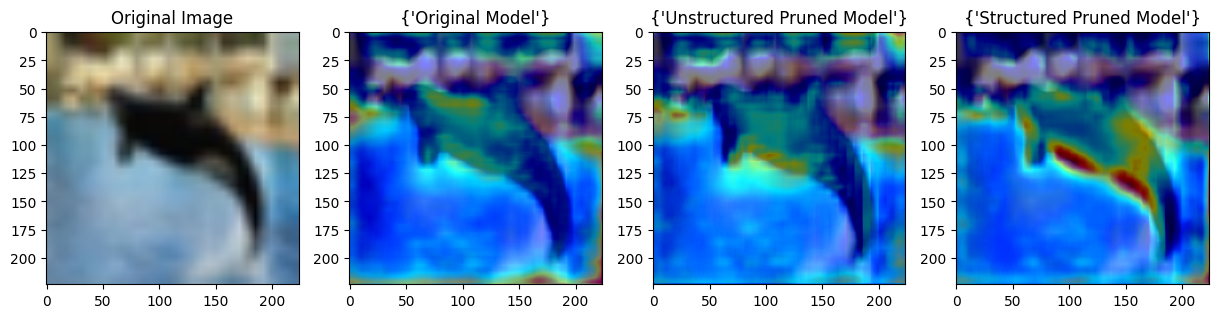

In [48]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Ensure device is set correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Denormalize function for visualizing the original image
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    tensor = tensor * std + mean
    return tensor

# Function to get a single random image from the test loader
def get_random_img(test_loader):
    import random
    random_index = random.randint(0, len(test_loader.dataset) - 1)
    input_tensor, label = test_loader.dataset[random_index]
    input_tensor = input_tensor.unsqueeze(0).to(device)
    
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)
    denorm_tensor = denormalize(input_tensor.squeeze().cpu(), mean, std)

    rgb_img_unnormalized = denorm_tensor.permute(1, 2, 0).numpy()
    rgb_img_unnormalized = np.clip(rgb_img_unnormalized, 0, 1)
    
    rgb_img = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.float32)
    rgb_img = np.clip(rgb_img, 0, 1)  # Ensure the image is in range [0, 1]
    
    print(f"\nRandom Index: {random_index}, Label: {label}\n")
    
    return input_tensor, rgb_img, rgb_img_unnormalized, label

# Function to visualize Grad-CAM for the same image across different models
def visualize_gradcam(models, target_layers, model_names, test_loader):
    input_tensor, rgb_img, rgb_img_unnormalized, label = get_random_img(test_loader)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(models) + 1, 1)
    plt.imshow(rgb_img_unnormalized)
    plt.title('Original Image')

    # Apply Grad-CAM for each model and display results side-by-side
    for i, (model, target_layer, model_name) in enumerate(zip(models, target_layers, model_names), start=2):
        with GradCAM(model=model, target_layers=target_layer) as cam:
            grayscale_cam = cam(input_tensor=input_tensor)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            plt.subplot(1, len(models) + 1, i)
            plt.imshow(visualization)
            plt.title({model_name})

    plt.show()

# Define the target layers for Grad-CAM in each model
# Typically, you might want to select convolutional layers, e.g., [features[i] for i in [0, 5, 10, 15, 20]]
target_layers_original = [original_model.features[i] for i in [0, 5, 10, 15, 20]]
target_layers_unstructured = [unstructure_pruned_model.features[i] for i in [0, 5, 10, 15, 20]]
target_layers_structured = [pruned_model.features[i] for i in [0, 5, 10, 15, 20]]

# Define the models, target layers, and model names
models = [original_model, unstructure_pruned_model, pruned_model]
target_layers = [target_layers_original, target_layers_unstructured, target_layers_structured]
model_names = ['Original Model', 'Unstructured Pruned Model', 'Structured Pruned Model']

# Run the Grad-CAM visualization
visualize_gradcam(models, target_layers, model_names, test_loader)


In [43]:
import torchvision.models as models
# Define the VGG-11 model without batch normalization and adjust for CIFAR-100 if applicable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = models.vgg11()
original_model.classifier[6] = torch.nn.Linear(4096, 100)  # Adjust for CIFAR-100 classes

# Load the saved state dict into the original model
model_path = '/kaggle/input/original-vgg11/vgg11_finetuned.pth'
original_model.load_state_dict(torch.load(model_path))
original_model = original_model.to(device)

print("Original model loaded successfully.")




/tmp/ipykernel_30/975950794.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load(model_path))


Original model loaded successfully.


Evaluating model at sparsity level: 0.4
Training Loss: 0.6612
Training Loss: 0.6675
Sparsity: 0.4, Accuracy: 67.93%
Evaluating model at sparsity level: 0.5
Training Loss: 1.2661
Training Loss: 1.2674
Sparsity: 0.5, Accuracy: 58.89%
Evaluating model at sparsity level: 0.6
Training Loss: 2.9070
Training Loss: 2.9057
Sparsity: 0.6, Accuracy: 34.81%
Evaluating model at sparsity level: 0.7
Training Loss: 4.3893
Training Loss: 4.3803
Sparsity: 0.7, Accuracy: 17.11%
Evaluating model at sparsity level: 0.8
Training Loss: 5.7380
Training Loss: 5.7371
Sparsity: 0.8, Accuracy: 2.50%
Evaluating model at sparsity level: 0.9
Training Loss: 6.4791
Training Loss: 6.4811
Sparsity: 0.9, Accuracy: 1.28%


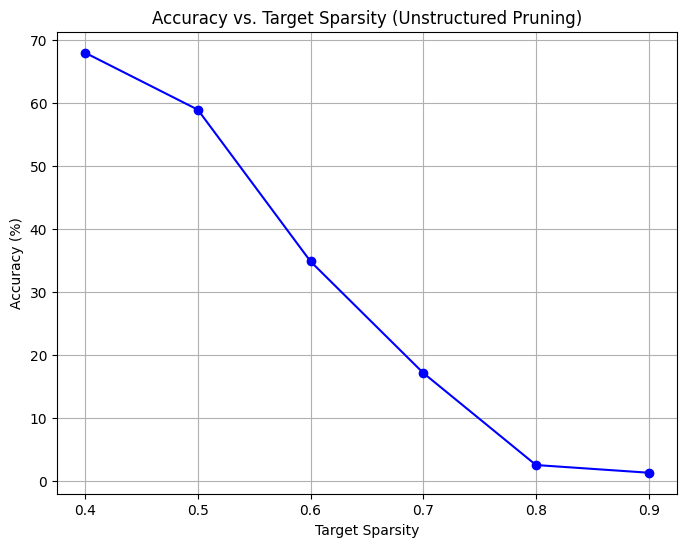

In [45]:
import torch
import matplotlib.pyplot as plt
from copy import deepcopy

# Define sparsity levels for unstructured pruning
target_sparsities = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []

# Function to perform unstructured pruning and evaluate model at given sparsity
def unstructured_prune_and_evaluate(model, sparsity, dataloader, fine_tune_epochs=2):
    pruned_model = deepcopy(model)
    
    # Apply unstructured pruning
    for name, param in pruned_model.named_parameters():
        if param.dim() > 1:  # Apply pruning to weight tensors only
            fine_grained_prune(param, sparsity)  # Use your unstructured pruning function
    
#     # Optional: Fine-tune pruned model for a few epochs to restore accuracy
#     optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.001, momentum=0.9)
#     criterion = torch.nn.CrossEntropyLoss()
    
    for _ in range(fine_tune_epochs):
        train(pruned_model, dataloader['train'], criterion, optimizer)
    
    # Evaluate pruned model on test set
    accuracy = evaluate(pruned_model, dataloader['test'])
    return accuracy

# Loop through each target sparsity, prune model, and evaluate accuracy
for sparsity in target_sparsities:
    print(f"Evaluating model at sparsity level: {sparsity}")
    accuracy = unstructured_prune_and_evaluate(original_model, sparsity, dataloader)
    accuracies.append(accuracy)
    print(f"Sparsity: {sparsity}, Accuracy: {accuracy:.2f}%")

# Plot Accuracy vs. Target Sparsity
plt.figure(figsize=(8, 6))
plt.plot(target_sparsities, accuracies, marker='o', color='b')
plt.xlabel("Target Sparsity")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Target Sparsity (Unstructured Pruning)")
plt.grid(True)
plt.show()
